# Тема: Прогнозування часових рядів на основі виручки таксі за день
### Виконав: ст. гр. КНСШ-11 Гонсьор Юрій

### Dataset: [NYC Taxi Trip Data](https://archive.org/details/nycTaxiTripData2013)

In [1]:

%reload_ext autoreload
%autoreload 2
import os

import pandas as pd
import pyspark.sql.types as t
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

from config import init_spark

os.environ['HADOOP_HOME'] = 'C:/hadoop'
os.environ['PATH'] += os.pathsep + 'C:/hadoop/bin'


In [6]:
def create_df_example(spark: SparkSession) -> DataFrame:
    data = [("Alice", 20), ("Bob", 30), ("Charlie", 50)]
    schema = t.StructType([t.StructField("Name", t.StringType(), True),
                           t.StructField("Age", t.IntegerType(), True)])
    return spark.createDataFrame(data, schema)

In [2]:
spark = init_spark()
spark

In [3]:
data = [("Alice", 20), ("Bob", 30), ("Charlie", 50)]
schema = t.StructType([t.StructField("Name", t.StringType(), True),
                       t.StructField("Age", t.IntegerType(), True)])
df = spark.createDataFrame(data, schema)

In [4]:
df.show()

+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 20|
|    Bob| 30|
|Charlie| 50|
+-------+---+



# Спроба загрузити датасет через pandas

In [14]:
import glob

df = pd.concat(map(pd.read_csv, glob.glob('dataset/trip_data/*.csv')))

C:\Users\YGonsor\AppData\Local\Temp\ipykernel_23924\1770361944.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('dataset/trip_data/*.csv')))
C:\Users\YGonsor\AppData\Local\Temp\ipykernel_23924\1770361944.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('dataset/trip_data/*.csv')))
C:\Users\YGonsor\AppData\Local\Temp\ipykernel_23924\1770361944.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('dataset/trip_data/*.csv')))
C:\Users\YGonsor\AppData\Local\Temp\ipykernel_23924\1770361944.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(map(pd.read_csv, glob.glob('dataset/trip_data/*.csv')))
C:\Users\YGonsor\AppData\Local\T

In [9]:
import glob

df_fare_data = pd.concat(map(pd.read_csv, glob.glob('dataset/fare_data/*.csv')))

![](static/pd_trip_data_finish.png)
![](static/pd_fare_data.png)

In [7]:
trip_df = spark.read.csv('dataset/trip_data', header=True)
trip_df.show(10)

In [12]:
fare_df = spark.read.csv('dataset/fare_data', header=True)
fare_df.show(10)


# Попередній аналіз датасету

In [281]:
from tables.TripTable import TripTable

spark = init_spark()
trip_table = TripTable(spark)

trip_table.show(n=10)

+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|    pickup_datetime|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+-------------------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N|2013-01-01 15:11:48|2013-01-01 15:18:10|              4|              382|          1.0|      -73.978165|      40.757977|        -73.98984|        40.75117|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...| 

In [22]:
num_cols = [f.name for f in trip_table.df.schema.fields if isinstance(f.dataType, t.NumericType)]
trip_table.df.describe(num_cols).show()
#173_179_759

+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+
|summary|         rate_code|   passenger_count| trip_time_in_secs|    trip_distance|  pickup_longitude|  pickup_latitude|dropoff_longitude| dropoff_latitude|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+
|  count|         173179759|         173179759|         173179759|        173179759|         173179759|        173179759|        173176321|        173176321|
|   mean|1.0337213022683558|1.7094193669596225| 811.9999416964196|8.305137246352254|-72.45156327315387|39.75292675450606|-72.4081049072237|39.72998349248398|
| stddev|0.3391333355137789|1.3767439366809258|15815.405665025886|6639.903068837684|11.291790226013369| 8.78031744246909|11.41710365961806|8.867562586757927|
|    min|                 0|                 0|     

In [29]:
from mapping.TripColumns import rate_code

trip_table.df.groupBy(rate_code).count().show(500)
# 1= Standard rate 2=JFK 3=Newark 4=Nassau or Westchester 5=Negotiated fare 6=Group ride

+---------+---------+
|rate_code|    count|
+---------+---------+
|        1|169249787|
|        6|     2303|
|        3|   259043|
|        5|   475336|
|        4|   121337|
|        8|       75|
|        2|  3040046|
|        0|    31578|
|      210|      158|
|       28|        6|
|        7|       49|
|        9|       16|
|       65|        5|
|      128|        4|
|       10|        2|
|       13|        2|
|       15|        1|
|       79|        2|
|      221|        1|
|       17|        1|
|      208|        1|
|      206|        1|
|       77|        2|
|      239|        1|
|      200|        1|
|       16|        1|
+---------+---------+



<BarContainer object of 26 artists>

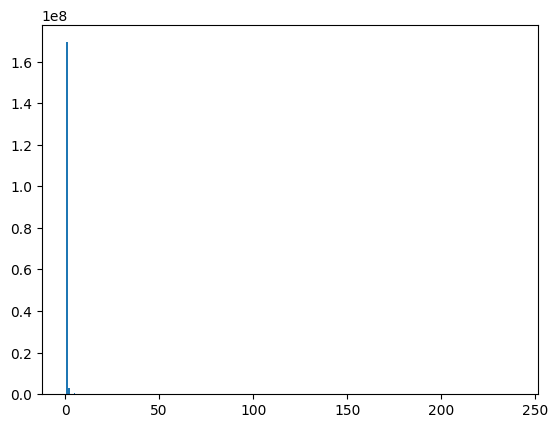

In [282]:
from matplotlib import pyplot as plt
from mapping.TripColumns import rate_code
rate_code_df = trip_table.df.groupBy(rate_code).count().toPandas().sort_values(rate_code)
plt.bar(rate_code_df.rate_code, rate_code_df['count'])

In [32]:
from mapping.TripColumns import passenger_count

trip_table.df.groupBy(passenger_count).count().show(500)

+---------------+---------+
|passenger_count|    count|
+---------------+---------+
|              1|121959711|
|              6|  6764789|
|              3|  7315829|
|              5| 10034696|
|              4|  3582103|
|              2| 23517494|
|              0|     5035|
|            208|       13|
|              9|       26|
|            255|        2|
|              7|       35|
|              8|       25|
|            129|        1|
+---------------+---------+



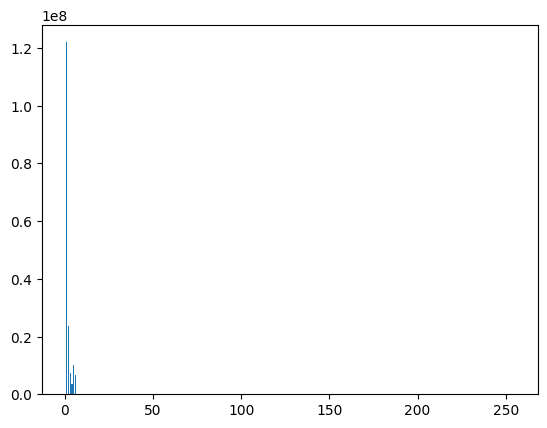

In [284]:
from mapping.TripColumns import passenger_count
passenger_count_df = trip_table.df.groupBy(passenger_count).count().toPandas().sort_values(passenger_count)
plt.bar(passenger_count_df.passenger_count, passenger_count_df['count'])
plt.show()

In [41]:
from mapping.TripColumns import trip_time_in_secs

(trip_table.df
 .select((col(trip_time_in_secs) / 60).cast("int").alias("trip_time_in_min"))
 .groupBy("trip_time_in_min")
 .count()
 .show(10000))

+----------------+--------+
|trip_time_in_min|   count|
+----------------+--------+
|              31|  806370|
|              85|    5127|
|             137|     209|
|              65|   30360|
|              53|   88294|
|             133|     250|
|              78|    9419|
|             108|     869|
|              34|  560174|
|             101|    1356|
|              81|    7231|
|              28| 1167594|
|              76|   11345|
|              27| 1324208|
|              26| 1499133|
|              44|  195031|
|             103|    1130|
|              12| 7936152|
|              91|    2894|
|              22| 2481311|
|             122|     413|
|             157|     100|
|              93|    2518|
|              47|  149514|
|             152|     141|
|               1| 2028954|
|              52|   95900|
|              13| 7156949|
|               6|11584977|
|              16| 5130930|
|              86|    4465|
|               3| 8087419|
|              20| 3

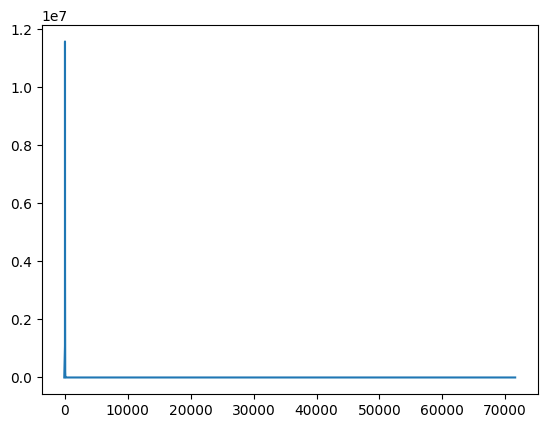

In [293]:
from mapping.TripColumns import trip_time_in_secs
trip_time_in_secs_df = (trip_table.df
                        .select((col(trip_time_in_secs) / 60).cast("int").alias("trip_time_in_min"))
                        .groupBy("trip_time_in_min")
                        .count()
                        .toPandas()
                        .sort_values("trip_time_in_min"))
plt.plot(trip_time_in_secs_df.trip_time_in_min, trip_time_in_secs_df['count'])

In [290]:
from mapping.TripColumns import trip_distance

(trip_table.df
 .select((col(trip_distance)).cast('int'))
 .groupBy(trip_distance)
 .count()
 .show(1000))

+-------------+--------+
|trip_distance|   count|
+-------------+--------+
|           31|    4402|
|           34|    3075|
|           28|   12030|
|           27|   12376|
|           26|   14698|
|           44|     650|
|           12|  748961|
|           22|   84015|
|            1|57584143|
|           52|     358|
|           13|  459205|
|            6| 3446154|
|           16|  617210|
|            3|15497927|
|           20|  281422|
|           40|    1193|
|           57|     223|
|           48|     470|
|            5| 5393243|
|           19|  425646|
|           41|    1091|
|           15|  378637|
|           43|     760|
|           37|    1912|
|           17|  962146|
|            9| 2084541|
|           72|      83|
|           35|    2767|
|            4| 8654736|
|            8| 2097914|
|           23|   38843|
|           39|    1364|
|            7| 2316288|
|           10| 1757683|
|           50|     534|
|           38|    1561|
|           25|   17126|


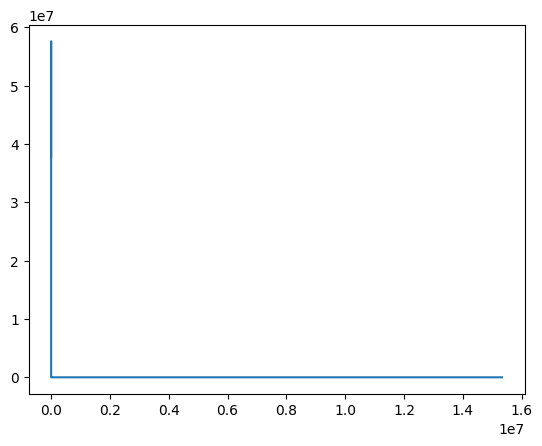

In [294]:
from mapping.TripColumns import trip_distance
trip_distance_df = (trip_table.df
                    .select((col(trip_distance)).cast('int'))
                    .groupBy(trip_distance)
                    .count()
                    .toPandas()
                    .sort_values(trip_distance))
plt.plot(trip_distance_df.trip_distance, trip_distance_df['count'])

In [23]:
from mapping.TripColumns import vendor_id

trip_table.df.groupBy(vendor_id).count().show(1000)

+---------+--------+
|vendor_id|   count|
+---------+--------+
|      CMT|85748971|
|      VTS|85860697|
+---------+--------+



In [6]:
trip_table = TripTable(spark)
trip_table.count()

#173_179_759 -> 171_609_668

171609668

### Після попередньої обробки датасету TripData кількість рядків зменшилась на 1.5М

In [295]:
from tables.FareTable import FareTable

spark = init_spark()
fareTable = FareTable(spark)
fareTable.show()

+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|vendor_id|    pickup_datetime|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+---------+-------------------+------------+-----------+---------+-------+----------+------------+------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|2013-01-01 15:11:48|         CSH|        6.5|      0.0|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-06 00:18:35|         CSH|        6.0|      0.5|    0.5|       0.0|         0.0|         7.0|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|2013-01-05 18:49:41|         CSH|        5.5|      1.0|    0.5|       0.0|         0.0|         7.0|
|DFD2202EE08F7A8DC...|51EE87E3205C985EF...|      CMT|2013-01-07 23:54:15|   

In [27]:
fareTable.df.count()
# 173_179_759

173179759

In [296]:
fareTable.fare_schema

StructType([StructField('medallion', StringType(), False), StructField('hack_license', StringType(), False), StructField('vendor_id', StringType(), False), StructField('pickup_datetime', TimestampType(), False), StructField('payment_type', StringType(), False), StructField('fare_amount', FloatType(), False), StructField('surcharge', FloatType(), False), StructField('mta_tax', FloatType(), False), StructField('tip_amount', FloatType(), False), StructField('tolls_amount', FloatType(), False), StructField('total_amount', FloatType(), False)])

In [297]:
num_cols = [f.name for f in fareTable.df.schema.fields if isinstance(f.dataType, t.NumericType)]
fareTable.df.describe(num_cols).show()


+-------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|       fare_amount|          surcharge|            mta_tax|        tip_amount|      tolls_amount|      total_amount|
+-------+------------------+-------------------+-------------------+------------------+------------------+------------------+
|  count|         173179759|          173179759|          173179759|         173179759|         173179759|         173179759|
|   mean|12.350179522927595|0.31934740878057855| 0.4982070178884221|1.3651019000996143|0.2500290074862975|14.790096624647008|
| stddev|17.617817347856057| 0.4093621795321131|0.03477811964712744| 2.193723798436221|1.2135947987960785|  69.0272489255159|
|    min|           -1430.0|              -19.5|               -0.5|            -96.82|            -22.25|           -1430.0|
|    max|         158995.81|              854.5|              80.05|            888.19|            960.09|          68

In [299]:
from mapping.FareColumns import total_amount
total_amount_in_tenth_df = fareTable.df.select(
    (col(total_amount) / 10).cast("int").alias("total_amount_in_tenth")).groupBy(
    "total_amount_in_tenth").count().toPandas()

In [306]:
total_amount_in_tenth_df.sort_values("total_amount_in_tenth", inplace=True)
total_amount_in_tenth_df.head(500)

total_amount_in_tenth  count
97                    -143      1
84                     -46      1
96                     -29      1
68                     -27      1
108                    -26      1
..                     ...    ...
72                    6155      1
121                   8224      1
127                  15900      1
131                  54143      1
91                   68590      1

[132 rows x 2 columns]

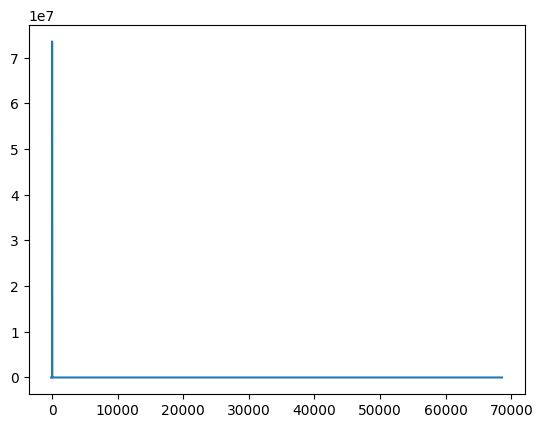

In [307]:
plt.plot(total_amount_in_tenth_df.total_amount_in_tenth, total_amount_in_tenth_df['count'])

In [303]:
from mapping.FareColumns import fare_amount
fare_amount_in_tenth_df = fareTable.df.select(
    (col(fare_amount) / 10).cast("int").alias("fare_amount_in_tenth")).groupBy(
    "fare_amount_in_tenth").count().toPandas()

In [308]:
fare_amount_in_tenth_df.sort_values("fare_amount_in_tenth", inplace=True)
fare_amount_in_tenth_df.head(500)

fare_amount_in_tenth  count
88                   -143      1
113                   -65      1
112                   -64      2
104                   -63      1
72                    -46      1
..                    ...    ...
114                   702      1
103                   900      1
61                   6155      1
108                  8216      1
115                 15899      1

[118 rows x 2 columns]

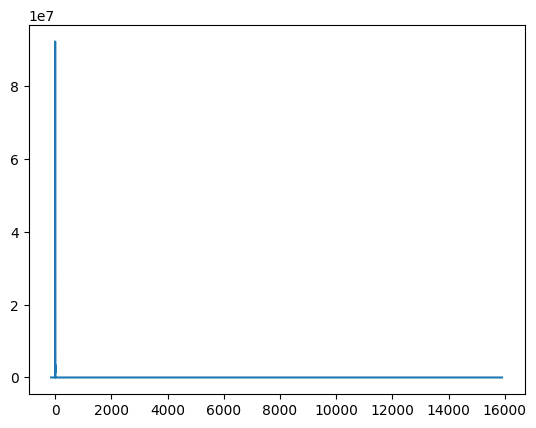

In [309]:
plt.plot(fare_amount_in_tenth_df.fare_amount_in_tenth, fare_amount_in_tenth_df['count'])


In [51]:
from mapping.FareColumns import vendor_id

fareTable.df.groupBy(vendor_id).count().show(1000)

+---------+--------+
|vendor_id|   count|
+---------+--------+
|      CMT|86684832|
|      VTS|86487635|
+---------+--------+



In [2]:

spark = init_spark()

In [15]:
from tables.TripTable import TripTable
from tables.FareTable import FareTable

trip_table = TripTable(spark)
fare_table = FareTable(spark)



In [728]:
from mapping.FareColumns import payment_type

fare_table.df.groupBy(payment_type).count().show(1000)

+------------+--------+
|payment_type|   count|
+------------+--------+
|         CSH|39926605|
|         DIS|  126477|
|         CRD|46109992|
|         NOC|  399084|
+------------+--------+



# Об'єднання датасетів

In [19]:
from mapping.TripColumns import hack_license, pickup_datetime, medallion
from pyspark.ml.feature import StringIndexer
from mapping.FareColumns import payment_type, payment_type_encoded

indexer = StringIndexer(inputCol=payment_type, outputCol=payment_type_encoded)
model = indexer.fit(fare_table.df)
labels = model.labels
df = (model.transform(fare_table.df)
      .drop(payment_type)
      .join(trip_table.df,
            on=[hack_license, pickup_datetime, medallion],
            how='inner')
      .drop(col(hack_license))
      .drop(col(medallion))
      .persist())


In [20]:
df.show()

+-------------------+-----------+---------+-------+----------+------------+------------+--------------------+---------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------------+
|    pickup_datetime|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|payment_type_encoded|rate_code|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag_binary|
+-------------------+-----------+---------+-------+----------+------------+------------+--------------------+---------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------------+
|2013-01-10 20:42:52|        6.0|      0.5|    0.5|       1.5|         0.0|         8.5|                 0.0|        1|2013-01-10 20:49:27|              1

In [35]:
df.schema

StructType([StructField('pickup_datetime', TimestampType(), True), StructField('fare_amount', FloatType(), True), StructField('surcharge', FloatType(), True), StructField('mta_tax', FloatType(), True), StructField('tip_amount', FloatType(), True), StructField('tolls_amount', FloatType(), True), StructField('total_amount', FloatType(), True), StructField('payment_type_encoded', DoubleType(), False), StructField('rate_code', IntegerType(), True), StructField('dropoff_datetime', TimestampType(), True), StructField('passenger_count', IntegerType(), True), StructField('trip_time_in_secs', IntegerType(), True), StructField('trip_distance', FloatType(), True), StructField('pickup_longitude', FloatType(), True), StructField('pickup_latitude', FloatType(), True), StructField('dropoff_longitude', FloatType(), True), StructField('dropoff_latitude', FloatType(), True), StructField('store_and_fwd_flag_binary', IntegerType(), False)])

In [33]:
df.write.parquet('dataset/joined_df.parquet')

In [34]:
with open('dataset/labels_list.txt', 'w') as file:
    for label in labels:
        file.write(f'{label}\n')

In [310]:
new_df = spark.read.parquet('dataset/joined_df.parquet')
new_df.show()

+-------------------+-----------+---------+-------+----------+------------+------------+--------------------+---------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------------+
|    pickup_datetime|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|payment_type_encoded|rate_code|   dropoff_datetime|passenger_count|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag_binary|
+-------------------+-----------+---------+-------+----------+------------+------------+--------------------+---------+-------------------+---------------+-----------------+-------------+----------------+---------------+-----------------+----------------+-------------------------+
|2013-01-09 21:32:56|       17.0|      0.5|    0.5|       4.5|         0.0|        22.5|                 0.0|        1|2013-01-09 21:42:58|              1

In [311]:
fare_amount_cropped_df = new_df.select(pickup_datetime, fare_amount).persist()

In [312]:
fare_amount_cropped_df.show()

+-------------------+-----------+
|    pickup_datetime|fare_amount|
+-------------------+-----------+
|2013-01-09 21:32:56|       17.0|
|2013-01-16 20:02:02|        4.0|
|2013-01-17 22:54:46|        9.5|
|2013-01-18 22:34:28|       10.5|
|2013-01-23 21:16:01|       10.5|
|2013-01-30 22:00:52|        3.0|
|2013-03-01 18:56:36|        5.5|
|2013-03-21 02:36:24|        4.5|
|2013-03-30 04:01:00|        8.5|
|2013-04-12 00:27:00|       17.0|
|2013-04-16 20:23:00|       19.5|
|2013-05-23 01:25:54|        7.5|
|2013-05-23 18:04:16|       35.5|
|2013-07-16 21:36:12|       10.0|
|2013-07-25 01:12:05|       11.0|
|2013-08-10 01:54:59|       29.0|
|2013-09-22 01:18:44|        3.5|
|2013-10-16 21:15:16|       16.0|
|2013-11-01 04:38:02|        2.5|
|2013-11-22 03:15:53|       22.5|
+-------------------+-----------+
only showing top 20 rows



In [313]:
fare_amount_cropped_df.count()

85655777

# Аналіз часових рядів

In [315]:
from pyspark.sql.functions import hour, avg, count, sum
fare_amount_by_hour = (fare_amount_cropped_df.withColumn('hour', hour(col(pickup_datetime)))
                       .groupBy('hour')
                       .agg(avg(fare_amount).alias('fare_amount_avg'),
                            sum(fare_amount).alias('fare_amount_sum'),
                            count('*').alias('trips_per_hour'))
                       .toPandas())

In [317]:
fare_amount_by_hour.sort_values('hour', inplace=True)
fare_amount_by_hour

hour  fare_amount_avg  fare_amount_sum  trips_per_hour
22     0        12.489409     4.283278e+07         3429528
2      1        12.250035     3.155434e+07         2575857
21     2        12.209103     2.377836e+07         1947593
6      3        12.673322     1.821279e+07         1437097
13     4        14.346482     1.535229e+07         1070108
8      5        15.460009     1.397896e+07          904201
4      6        12.257143     2.306981e+07         1882152
16     7        11.512974     3.679311e+07         3195795
14     8        11.632246     4.519648e+07         3885447
12     9        11.625431     4.638722e+07         3990151
17    10        11.643971     4.511532e+07         3874565
19    11        11.816484     4.709572e+07         3985595
0     12        11.872323     5.001775e+07         4212971
3     13        12.252832     5.139225e+07         4194316
20    14        12.526299     5.392252e+07         4304745
10    15        12.556130     5.122965e+07         4080051
5     16        12.377974     4.068842e+07         3287163
11    17        12.146511     4.855695e+07         3997605
23    18        11.623138     5.856119e+07         5038329
9     19        11.234979     5.948568e+07         5294685
7     20        11.403859     5.754755e+07         5046323
18    21        11.725891     5.802673e+07         4948599
1     22        12.015408     5.774711e+07         4806088
15    23        12.392258     5.287545e+07         4266813

Text(0.5, 1.0, 'Number of trips per hour')

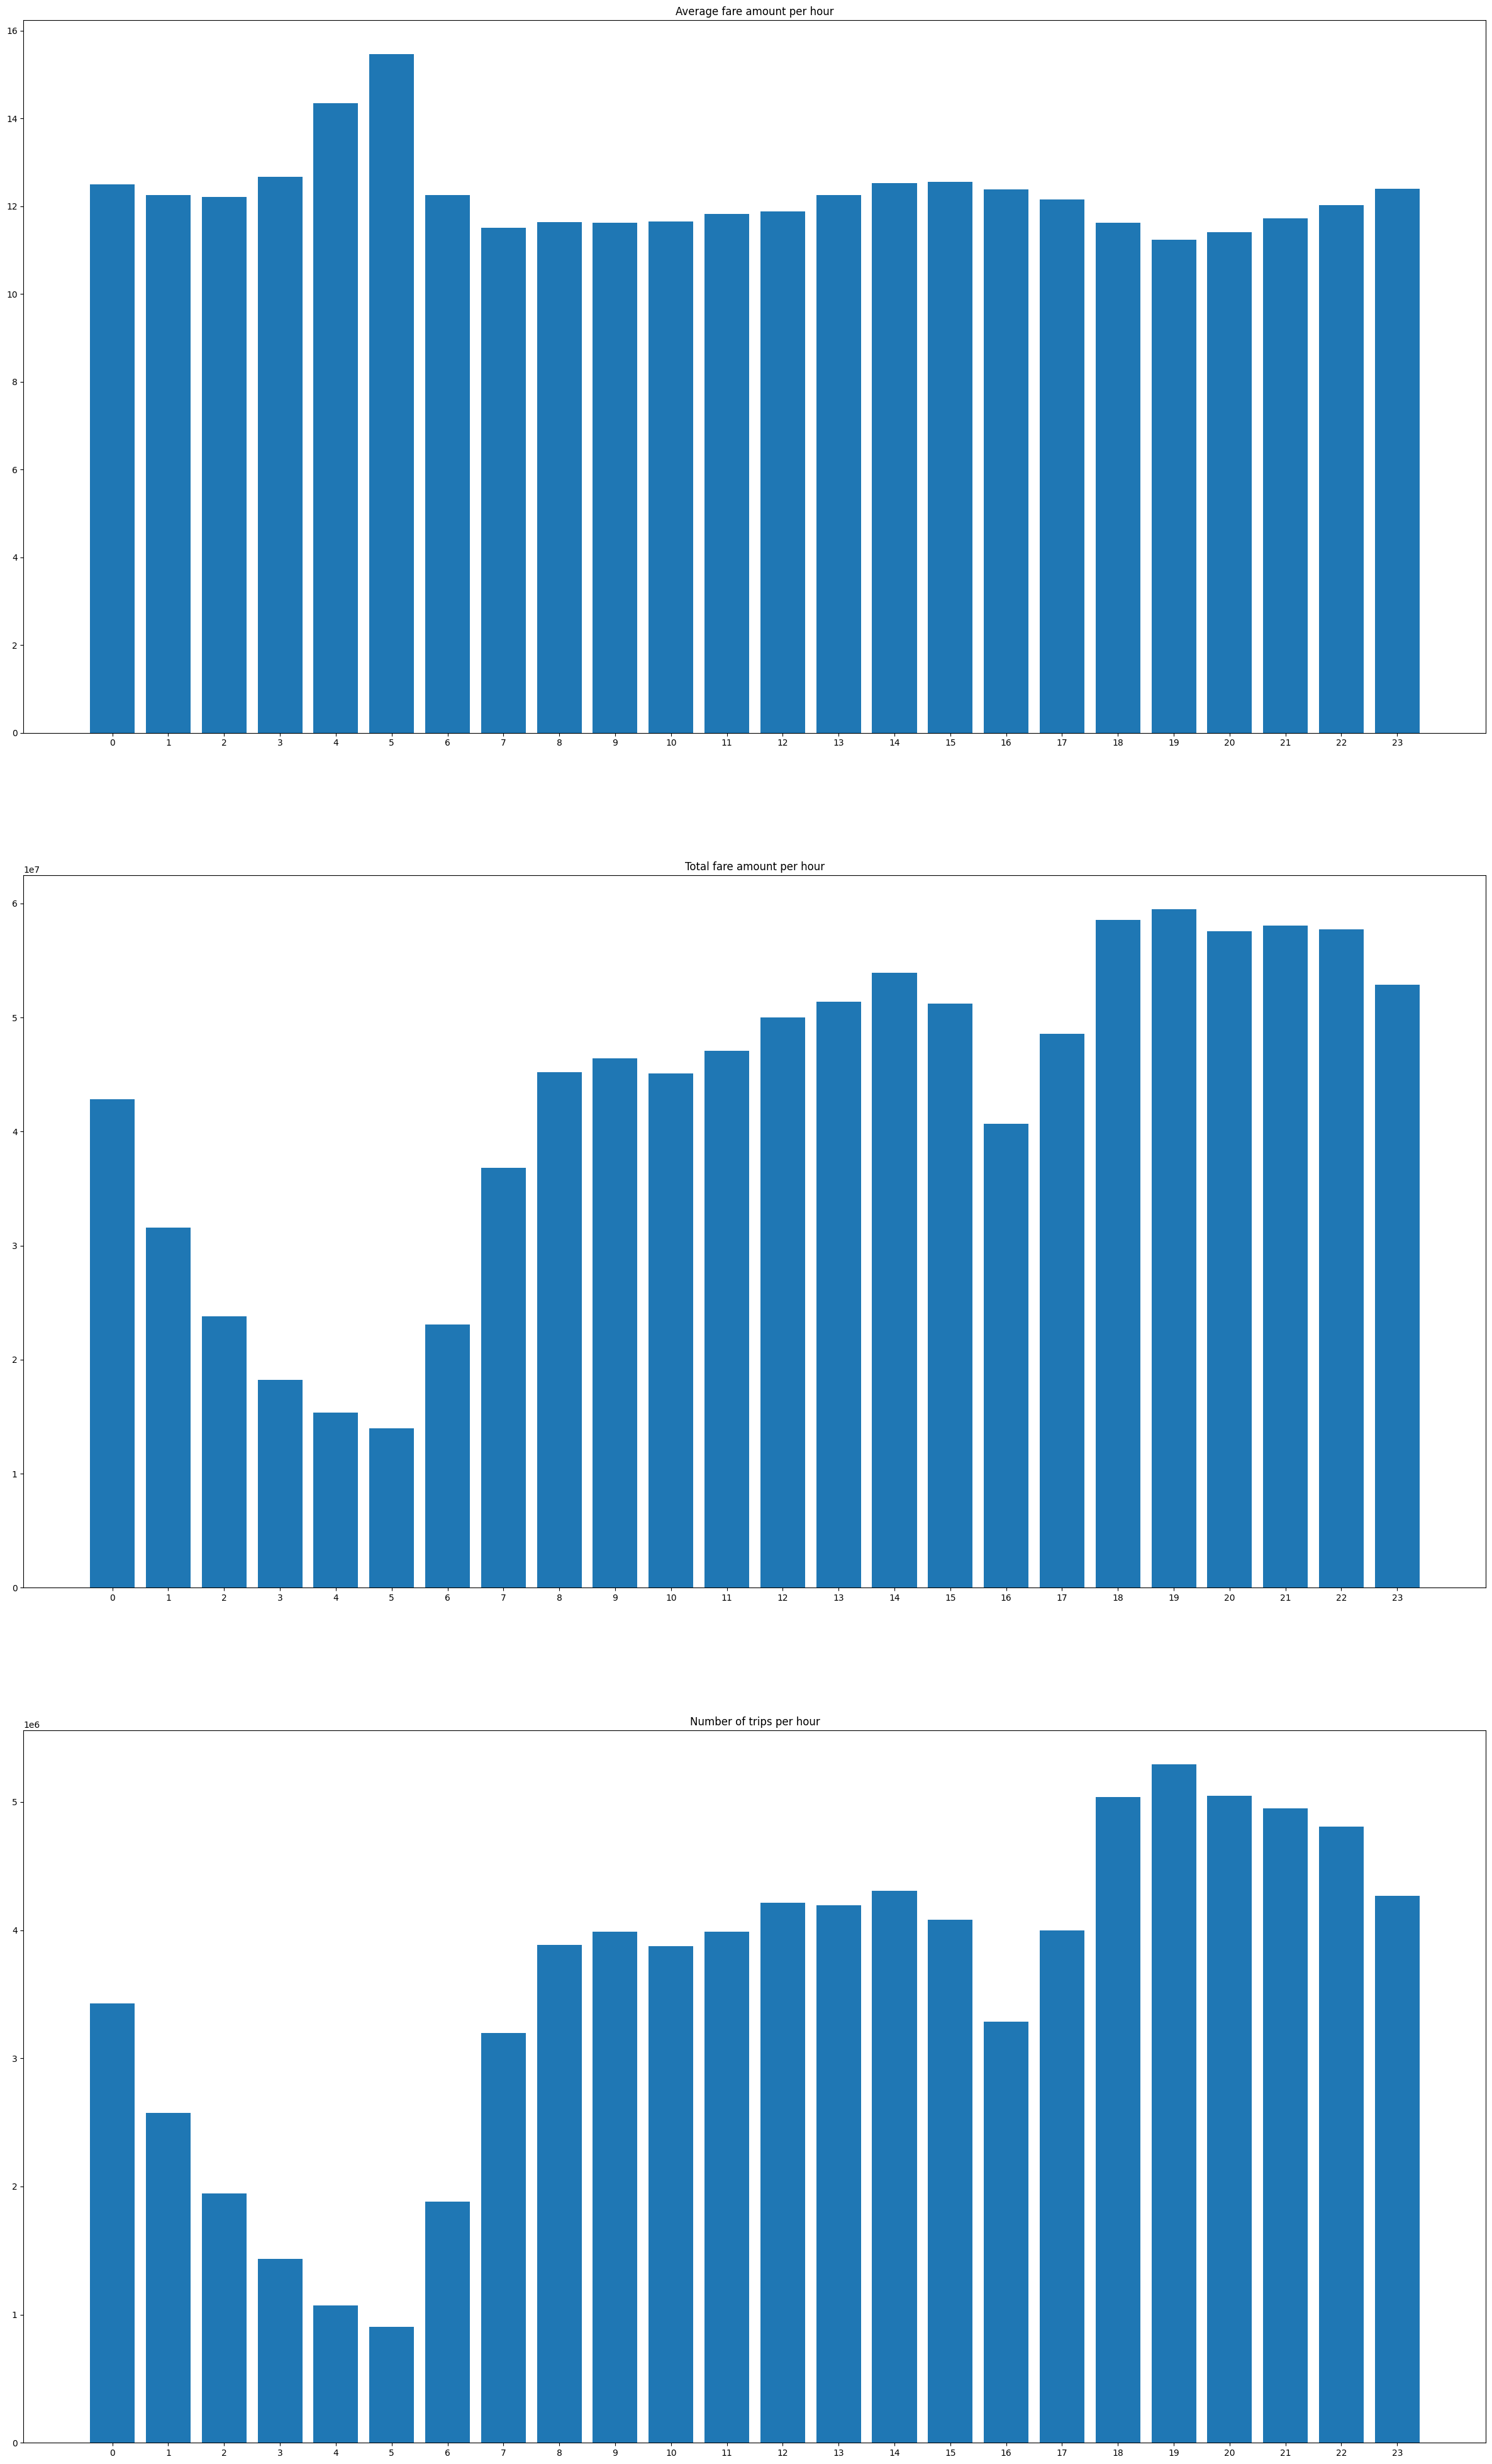

In [331]:
fig, ax = plt.subplots(3, figsize=(30, 50))

ax[0].bar(fare_amount_by_hour.hour, fare_amount_by_hour.fare_amount_avg)
ax[0].set_xticks(range(0, 24, 1))
ax[0].set_title('Average fare amount per hour')

ax[1].bar(fare_amount_by_hour.hour, fare_amount_by_hour.fare_amount_sum)
ax[1].set_xticks(range(0, 24, 1))
ax[1].set_title('Total fare amount per hour')

ax[2].bar(fare_amount_by_hour.hour, fare_amount_by_hour.trips_per_hour)
ax[2].set_xticks(range(0, 24, 1))
ax[2].set_title('Number of trips per hour')


In [335]:
from pyspark.sql.functions import dayofweek, avg, count, sum

fare_amount_by_day_of_week = (fare_amount_cropped_df.withColumn('day_of_week', dayofweek(col(pickup_datetime)))
                              .groupBy('day_of_week')
                              .agg(avg(fare_amount).alias('fare_amount_avg'),
                                   sum(fare_amount).alias('fare_amount_sum'),
                                   count('*').alias('trips_per_day_of_week'))
                              .toPandas())

In [342]:
fare_amount_by_day_of_week.sort_values('day_of_week', inplace=True)
fare_amount_by_day_of_week

day_of_week  fare_amount_avg  fare_amount_sum  trips_per_day_of_week
0            1        12.235385     1.398741e+08               11431930
6            2        12.020476     1.339497e+08               11143458
2            3        11.870509     1.442564e+08               12152500
4            4        12.019085     1.473190e+08               12257086
3            5        12.189684     1.534991e+08               12592541
1            6        12.123299     1.585060e+08               13074497
5            7        11.690016     1.520142e+08               13003765

Text(0.5, 1.0, 'Number of trips by day of week')

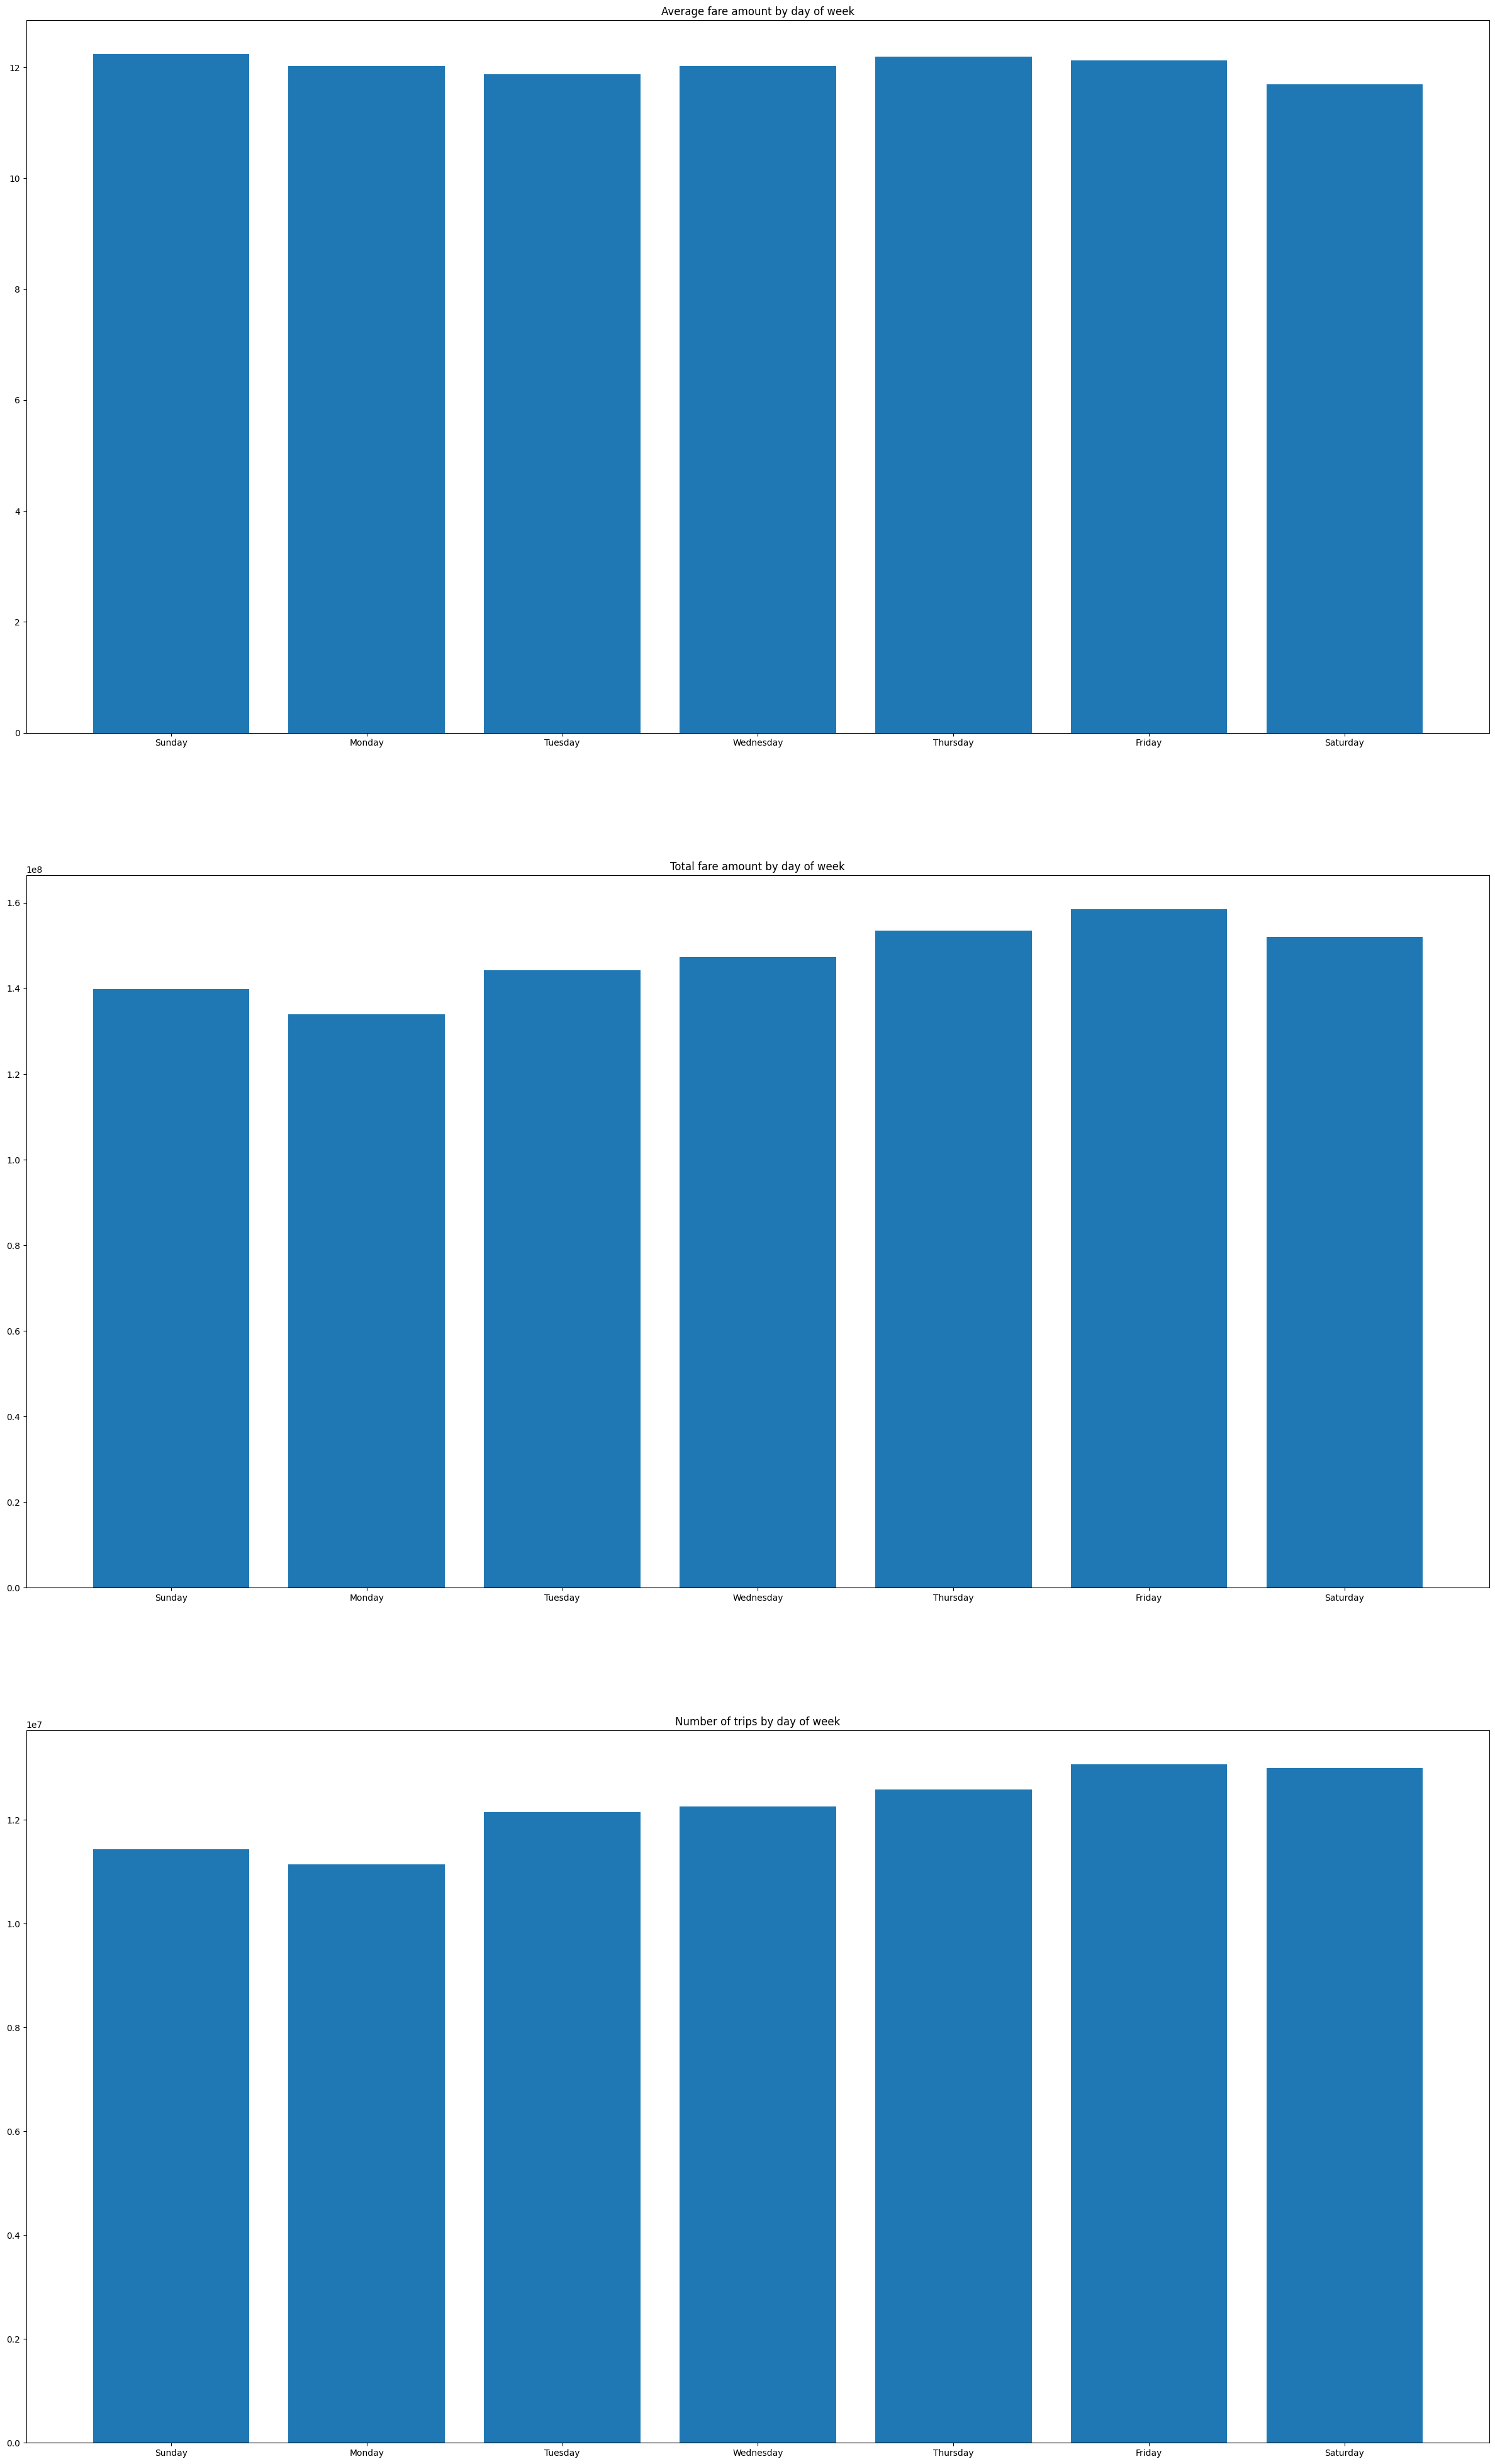

In [344]:
_, ax = plt.subplots(3, figsize=(30, 50))

labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

ax[0].bar(fare_amount_by_day_of_week.day_of_week, fare_amount_by_day_of_week.fare_amount_avg)
ax[0].set_xticks(range(1, 8, 1), labels)
ax[0].set_title('Average fare amount by day of week')

ax[1].bar(fare_amount_by_day_of_week.day_of_week, fare_amount_by_day_of_week.fare_amount_sum)
ax[1].set_xticks(range(1, 8, 1), labels)
ax[1].set_title('Total fare amount by day of week')

ax[2].bar(fare_amount_by_day_of_week.day_of_week, fare_amount_by_day_of_week.trips_per_day_of_week)
ax[2].set_xticks(range(1, 8, 1), labels)
ax[2].set_title('Number of trips by day of week')

In [435]:
from pyspark.sql.functions import dayofmonth, avg, count, sum

fare_amount_by_day_of_month = (fare_amount_cropped_df.withColumn('day_of_month', dayofmonth(col(pickup_datetime)))
                               .groupBy('day_of_month')
                               .agg(avg(fare_amount).alias('fare_amount_avg'),
                                    sum(fare_amount).alias('fare_amount_sum'),
                                    count('*').alias('trips_per_day_of_month'))
                               .toPandas())

In [436]:
fare_amount_by_day_of_month.sort_values('day_of_month', inplace=True)
fare_amount_by_day_of_month

day_of_month  fare_amount_avg  fare_amount_sum  trips_per_day_of_month
6              1        12.076519     3.394207e+07                 2810584
28             2        11.842621     3.344175e+07                 2823847
10             3        11.962996     3.355082e+07                 2804550
17             4        11.951403     3.310733e+07                 2770163
12             5        11.829702     3.349268e+07                 2831236
9              6        12.036740     3.400880e+07                 2825416
20             7        12.040471     3.439575e+07                 2856678
18             8        11.904723     3.330382e+07                 2797530
15             9        11.932175     3.371513e+07                 2825564
21            10        12.062292     3.431478e+07                 2844798
26            11        12.069031     3.215238e+07                 2664040
4             12        12.112706     3.528611e+07                 2913148
7             13        12.093079     3.529967e+07                 2918998
27            14        12.047083     3.459789e+07                 2871889
14            15        12.097842     3.484566e+07                 2880320
8             16        12.063781     3.489835e+07                 2892820
16            17        12.094219     3.473154e+07                 2871747
30            18        12.181425     3.459430e+07                 2839922
13            19        12.042447     3.500747e+07                 2907006
11            20        12.009851     3.505250e+07                 2918646
25            21        12.082269     3.396691e+07                 2811302
5             22        12.035266     3.452223e+07                 2868423
19            23        11.923012     3.446031e+07                 2890235
23            24        11.971334     3.312461e+07                 2766994
22            25        12.020591     3.225456e+07                 2683276
3             26        11.970785     3.301533e+07                 2757992
2             27        12.048540     3.284749e+07                 2726263
1             28        12.110700     3.258177e+07                 2690329
24            29        11.972220     2.948004e+07                 2462370
29            30        12.007880     2.978466e+07                 2480426
0             31        11.909396     1.964175e+07                 1649265

Text(0.5, 1.0, 'Number of trips by day of month')

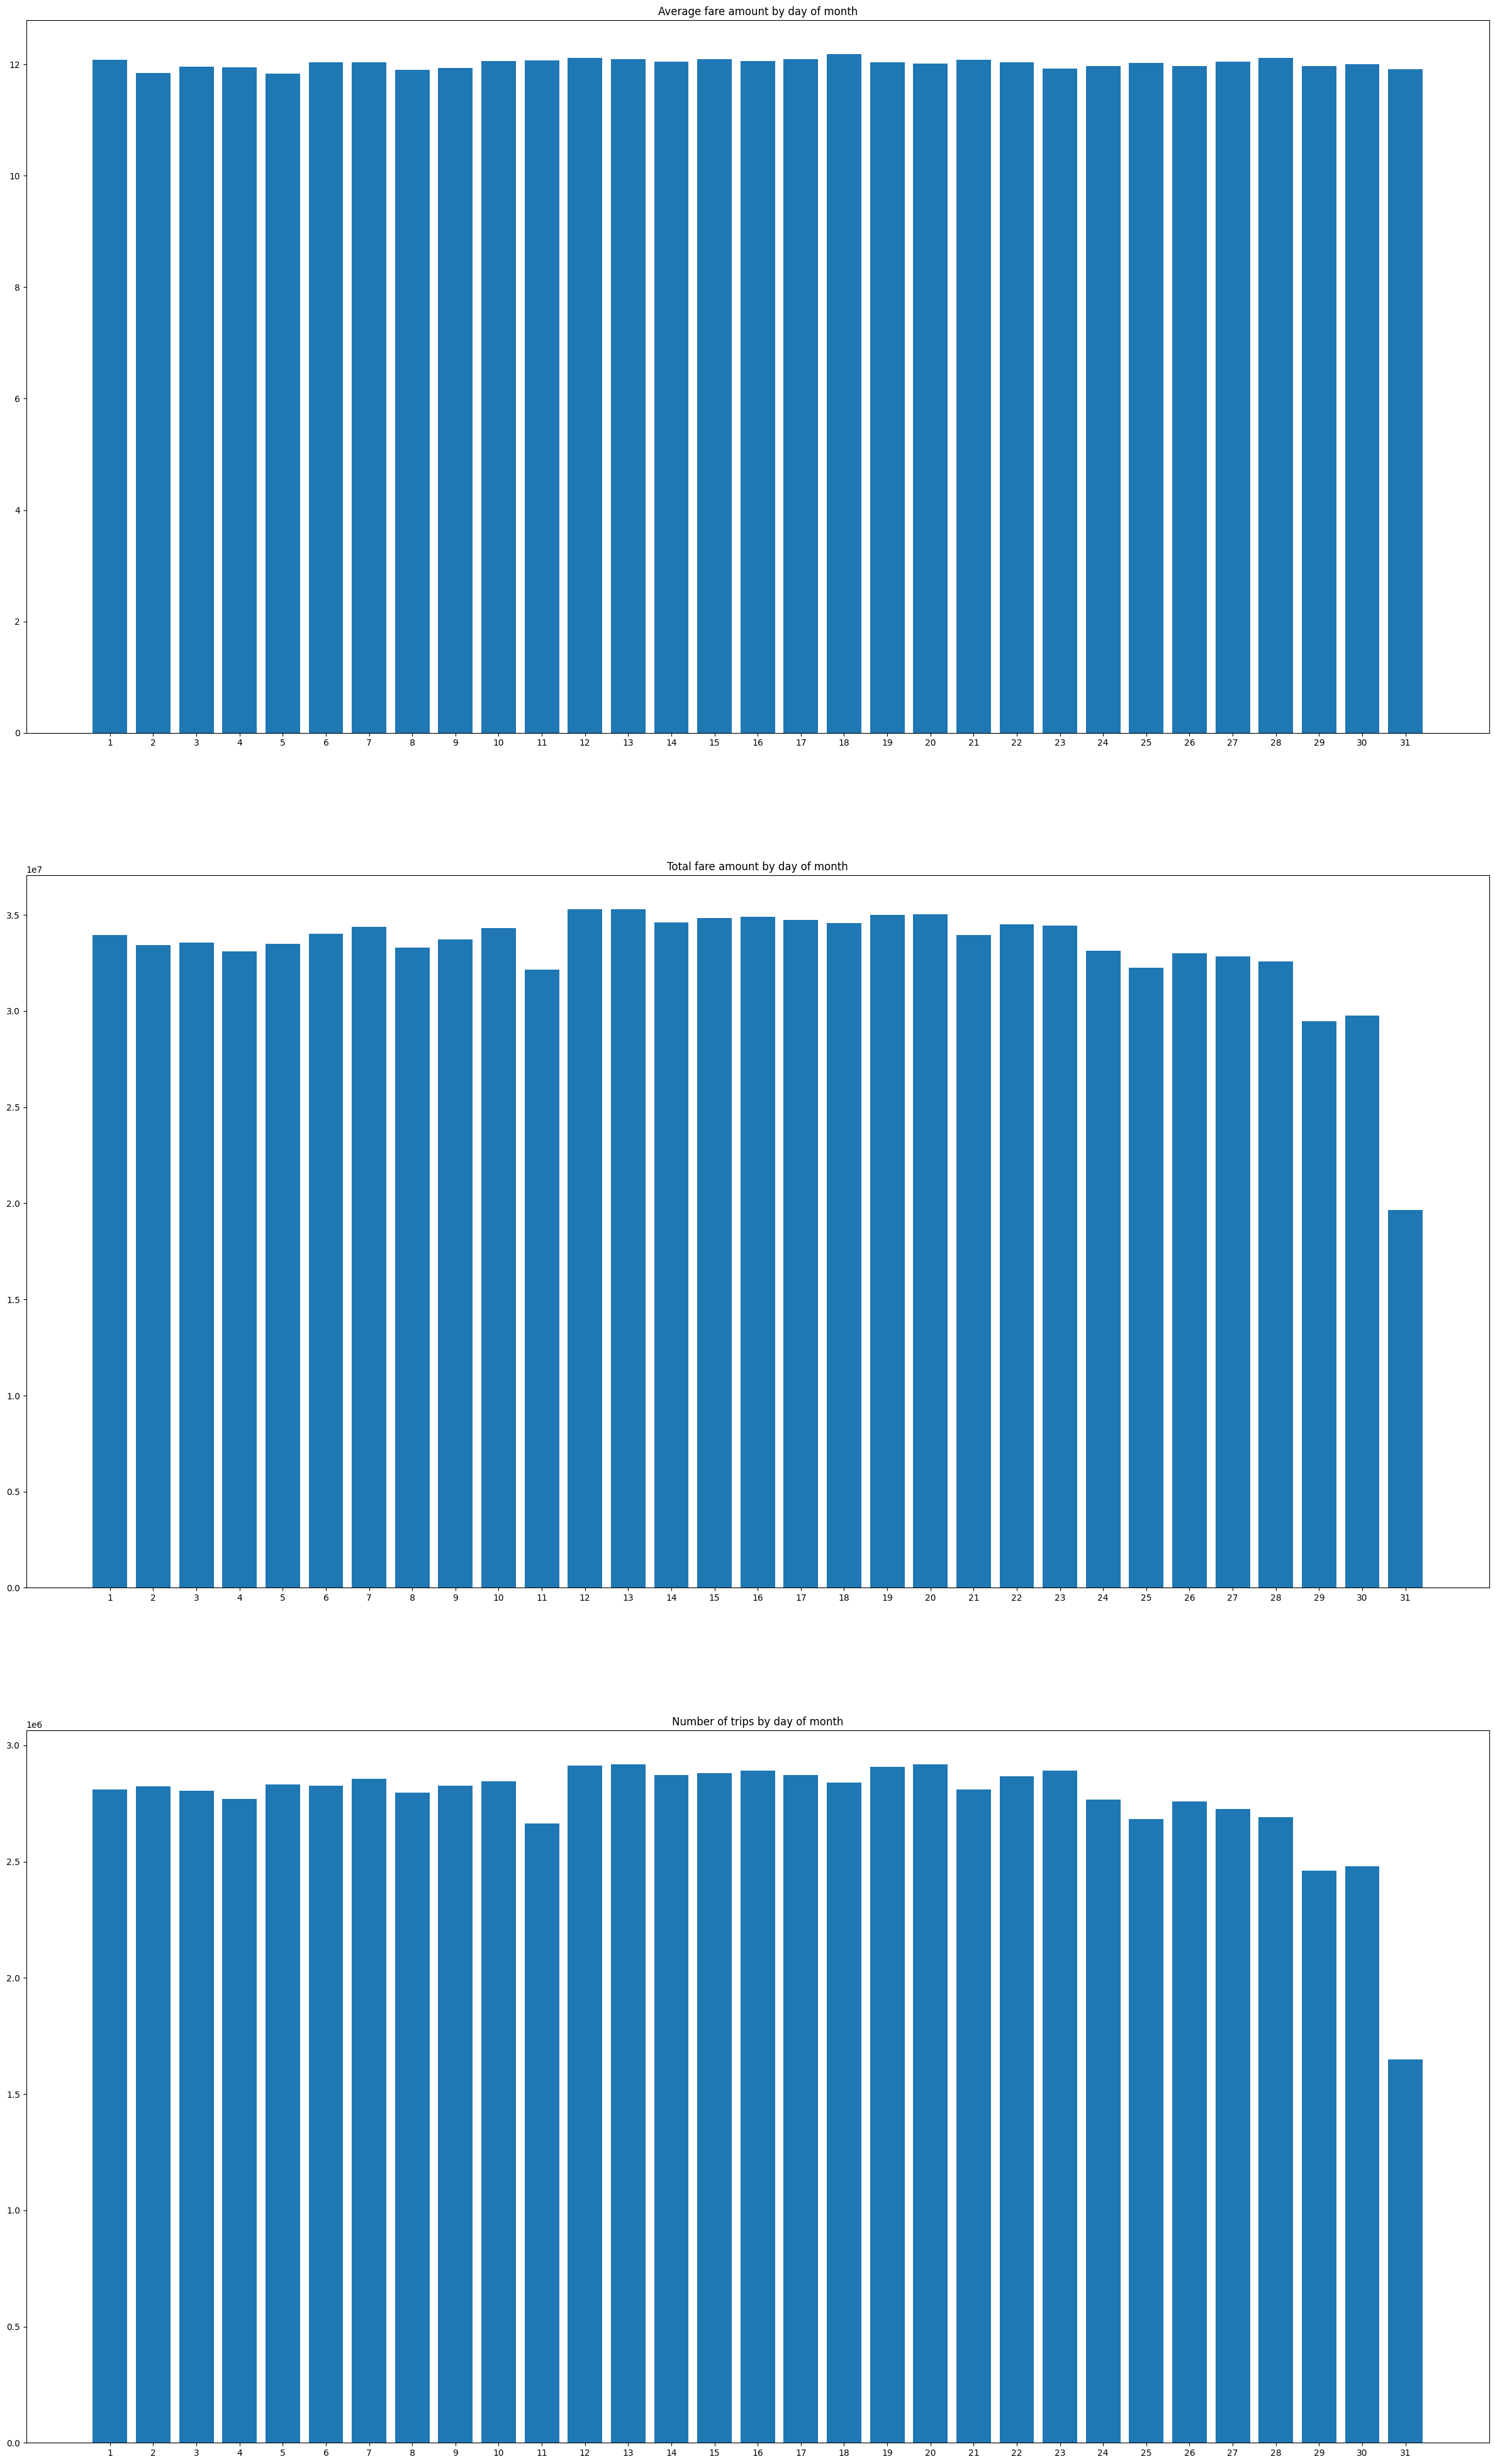

In [438]:
_, ax = plt.subplots(3, figsize=(30, 50))

ax[0].bar(fare_amount_by_day_of_month.day_of_month, fare_amount_by_day_of_month.fare_amount_avg)
ax[0].set_xticks(range(1, 32, 1))
ax[0].set_title('Average fare amount by day of month')

ax[1].bar(fare_amount_by_day_of_month.day_of_month, fare_amount_by_day_of_month.fare_amount_sum)
ax[1].set_xticks(range(1, 32, 1))
ax[1].set_title('Total fare amount by day of month')

ax[2].bar(fare_amount_by_day_of_month.day_of_month, fare_amount_by_day_of_month.trips_per_day_of_month)
ax[2].set_xticks(range(1, 32, 1))
ax[2].set_title('Number of trips by day of month')

In [345]:
from pyspark.sql.functions import month, avg, count, sum

fare_amount_by_month = (fare_amount_cropped_df.withColumn('month', month(col(pickup_datetime)))
                        .groupBy('month')
                        .agg(avg(fare_amount).alias('fare_amount_avg'),
                             sum(fare_amount).alias('fare_amount_sum'),
                             count('*').alias('trips_per_month'))
                        .toPandas())

In [346]:
fare_amount_by_month.sort_values('month', inplace=True)
fare_amount_by_month

month  fare_amount_avg  fare_amount_sum  trips_per_month
1       1        11.339291     8.371052e+07          7382342
11      2        11.413205     7.965615e+07          6979297
3       3        11.716677     9.212589e+07          7862800
6       4        11.926876     8.922452e+07          7480963
4       5        12.225211     9.196610e+07          7522660
2       6        12.271462     8.701996e+07          7091246
8       7        12.023798     8.139488e+07          6769482
7       8        12.303404     7.845975e+07          6377077
5       9        12.389310     8.523296e+07          6879557
9      10        12.301928     9.107489e+07          7403302
10     11        12.127952     8.571784e+07          7067792
0      12        12.257902     8.383496e+07          6839259

Text(0.5, 1.0, 'Number of trips by month')

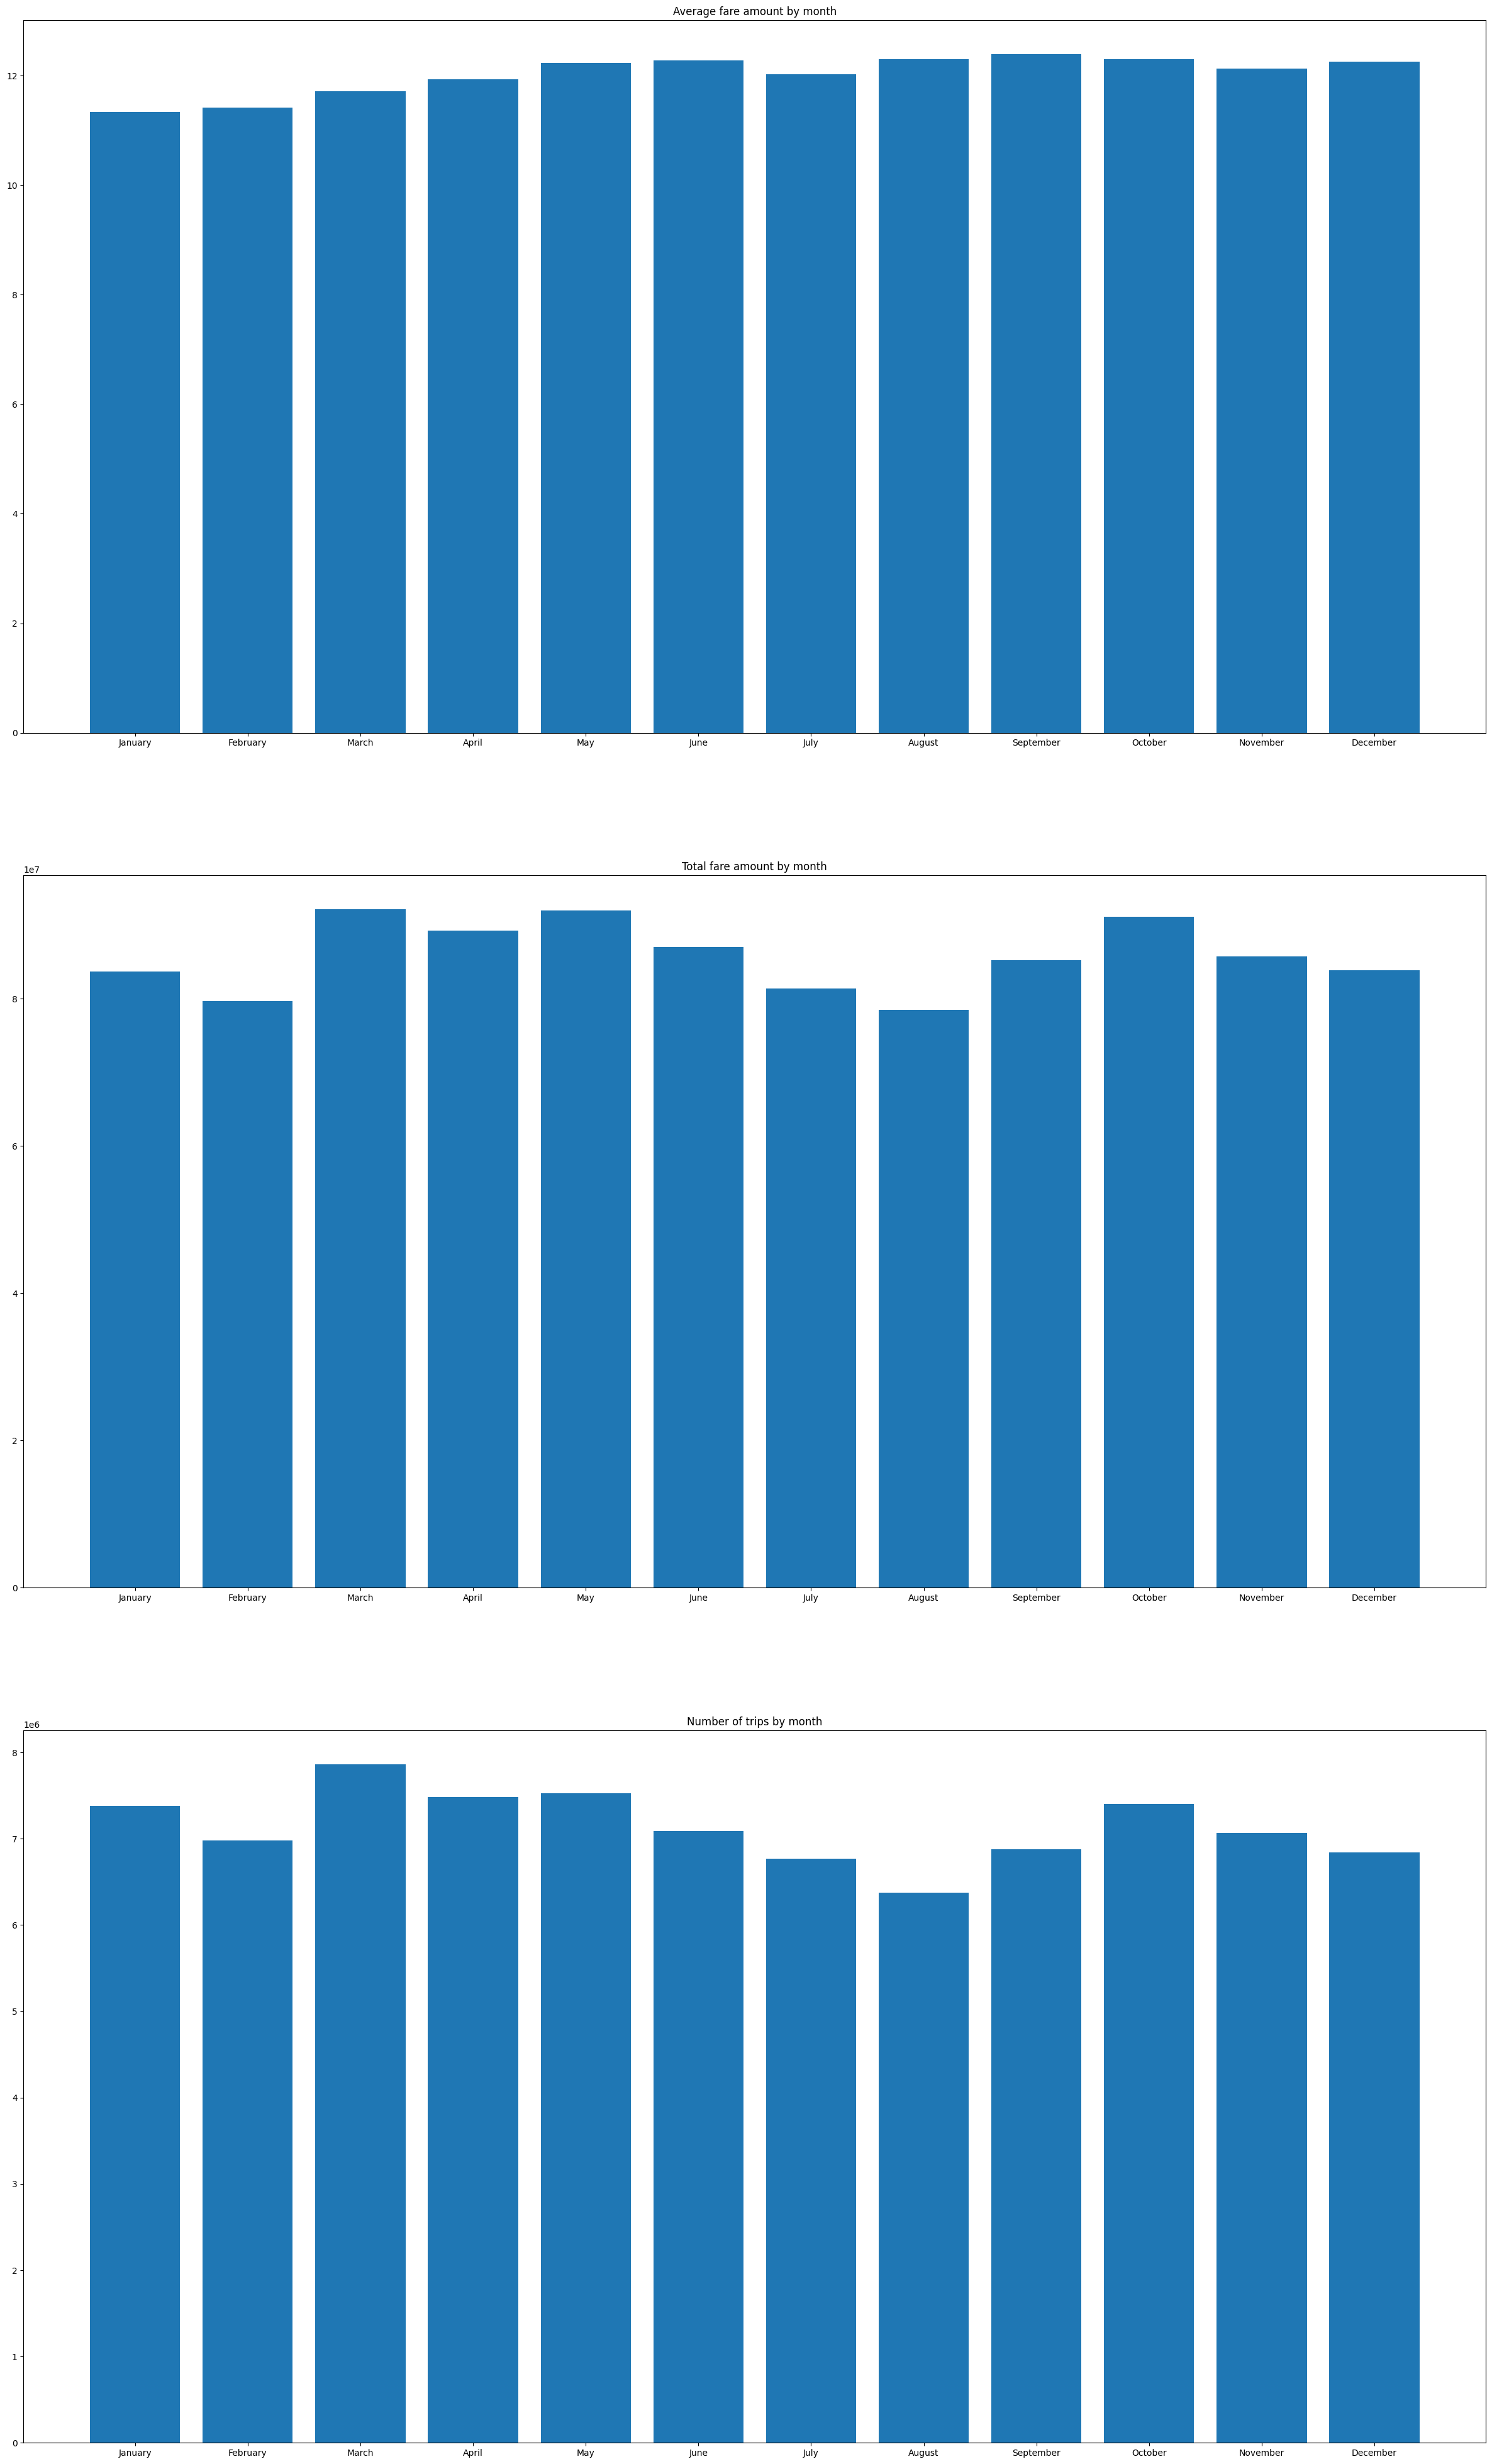

In [348]:
_, ax = plt.subplots(3, figsize=(30, 50))

labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November',
          'December']

ax[0].bar(fare_amount_by_month.month, fare_amount_by_month.fare_amount_avg)
ax[0].set_xticks(range(1, 13, 1), labels)
ax[0].set_title('Average fare amount by month')

ax[1].bar(fare_amount_by_month.month, fare_amount_by_month.fare_amount_sum)
ax[1].set_xticks(range(1, 13, 1), labels)
ax[1].set_title('Total fare amount by month')

ax[2].bar(fare_amount_by_month.month, fare_amount_by_month.trips_per_month)
ax[2].set_xticks(range(1, 13, 1), labels)
ax[2].set_title('Number of trips by month')

In [370]:
from pyspark.sql.functions import avg, count, sum, when, month

fare_amount_by_season = (fare_amount_cropped_df
                         .withColumn('season', when((month(col(pickup_datetime)).isin(12, 1, 2)), 1)
                                     .when((month(col(pickup_datetime)).isin(3, 4, 5)), 2)
                                     .when((month(col(pickup_datetime)).isin(6, 7, 8)), 3)
                                     .when((month(col(pickup_datetime)).isin(9, 10, 11)), 4))
                         .groupBy('season')
                         .agg(avg(fare_amount).alias('fare_amount_avg'),
                              sum(fare_amount).alias('fare_amount_sum'),
                              count('*').alias('trips_per_season'))
                         .toPandas())

In [371]:
fare_amount_by_season.sort_values('season', inplace=True)
fare_amount_by_season

season  fare_amount_avg  fare_amount_sum  trips_per_season
0       1        11.659961     2.472016e+08          21200898
3       2        11.952744     2.733165e+08          22866423
1       3        12.198684     2.468746e+08          20237805
2       4        12.272492     2.620257e+08          21350651

Text(0.5, 1.0, 'Number of trips by season')

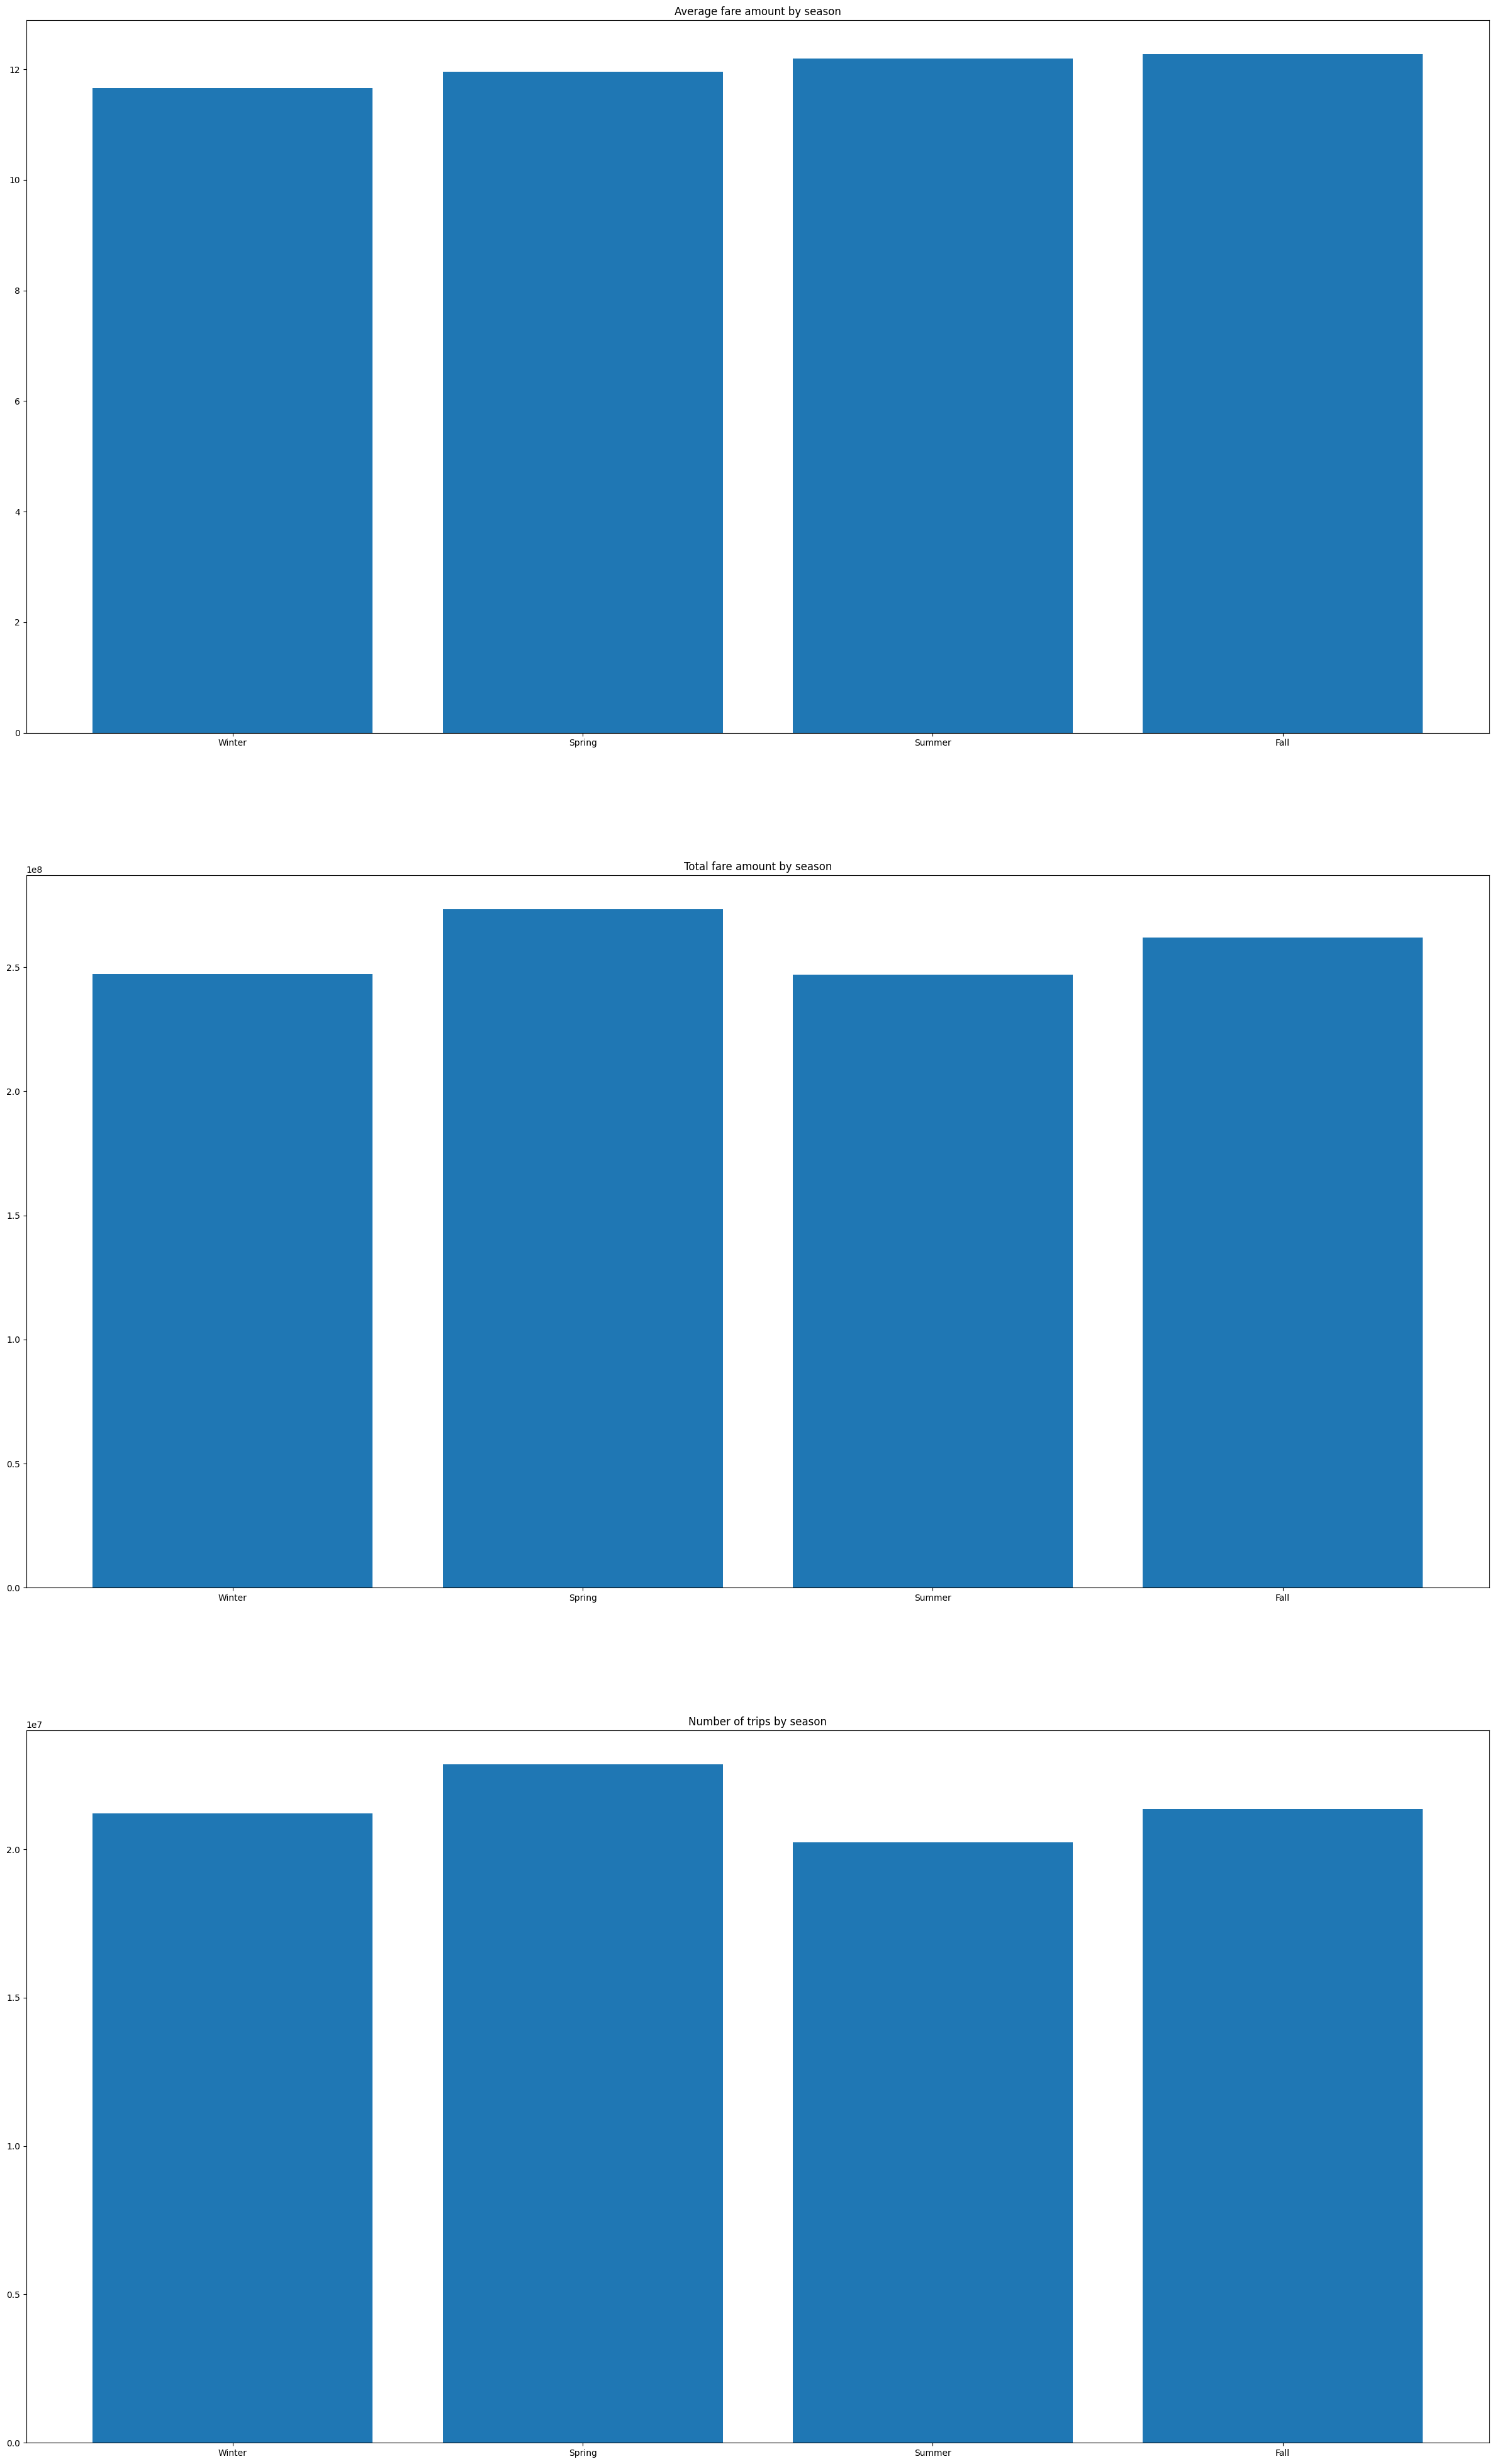

In [372]:
_, ax = plt.subplots(3, figsize=(30, 50))

labels = ['Winter', 'Spring', 'Summer', 'Fall']

ax[0].bar(fare_amount_by_season.season, fare_amount_by_season.fare_amount_avg)
ax[0].set_xticks(range(1, 5, 1), labels)
ax[0].set_title('Average fare amount by season')

ax[1].bar(fare_amount_by_season.season, fare_amount_by_season.fare_amount_sum)
ax[1].set_xticks(range(1, 5, 1), labels)
ax[1].set_title('Total fare amount by season')

ax[2].bar(fare_amount_by_season.season, fare_amount_by_season.trips_per_season)
ax[2].set_xticks(range(1, 5, 1), labels)
ax[2].set_title('Number of trips by season')

In [353]:
from pyspark.sql.functions import dayofyear, avg, count, sum

fare_amount_per_day_of_year = (fare_amount_cropped_df.withColumn('dayOfYear', dayofyear(col(pickup_datetime)))
                               .groupBy('dayOfYear')
                               .agg(avg(fare_amount).alias('fare_amount_avg'),
                                    sum(fare_amount).alias('fare_amount_sum'),
                                    count('*').alias('trips_by_day_of_year'))
                               .toPandas())

In [356]:
fare_amount_per_day_of_year.sort_values('dayOfYear', inplace=True)
fare_amount_per_day_of_year

dayOfYear  fare_amount_avg  fare_amount_sum  trips_by_day_of_year
80           1        12.392739     2.452151e+06                197870
324          2        11.521147     2.216761e+06                192408
97           3        11.192533     2.465726e+06                220301
180          4        10.974997     2.637665e+06                240334
123          5        11.014316     2.598773e+06                235945
..         ...              ...              ...                   ...
218        361        12.117226     2.278766e+06                188060
13         362        12.374064     2.387712e+06                192961
83         363        12.103771     2.444950e+06                201999
232        364        12.022767     2.405912e+06                200113
330        365        11.003735     2.499906e+06                227187

[365 rows x 4 columns]

Text(0.5, 1.0, 'Number of trips by day of year')

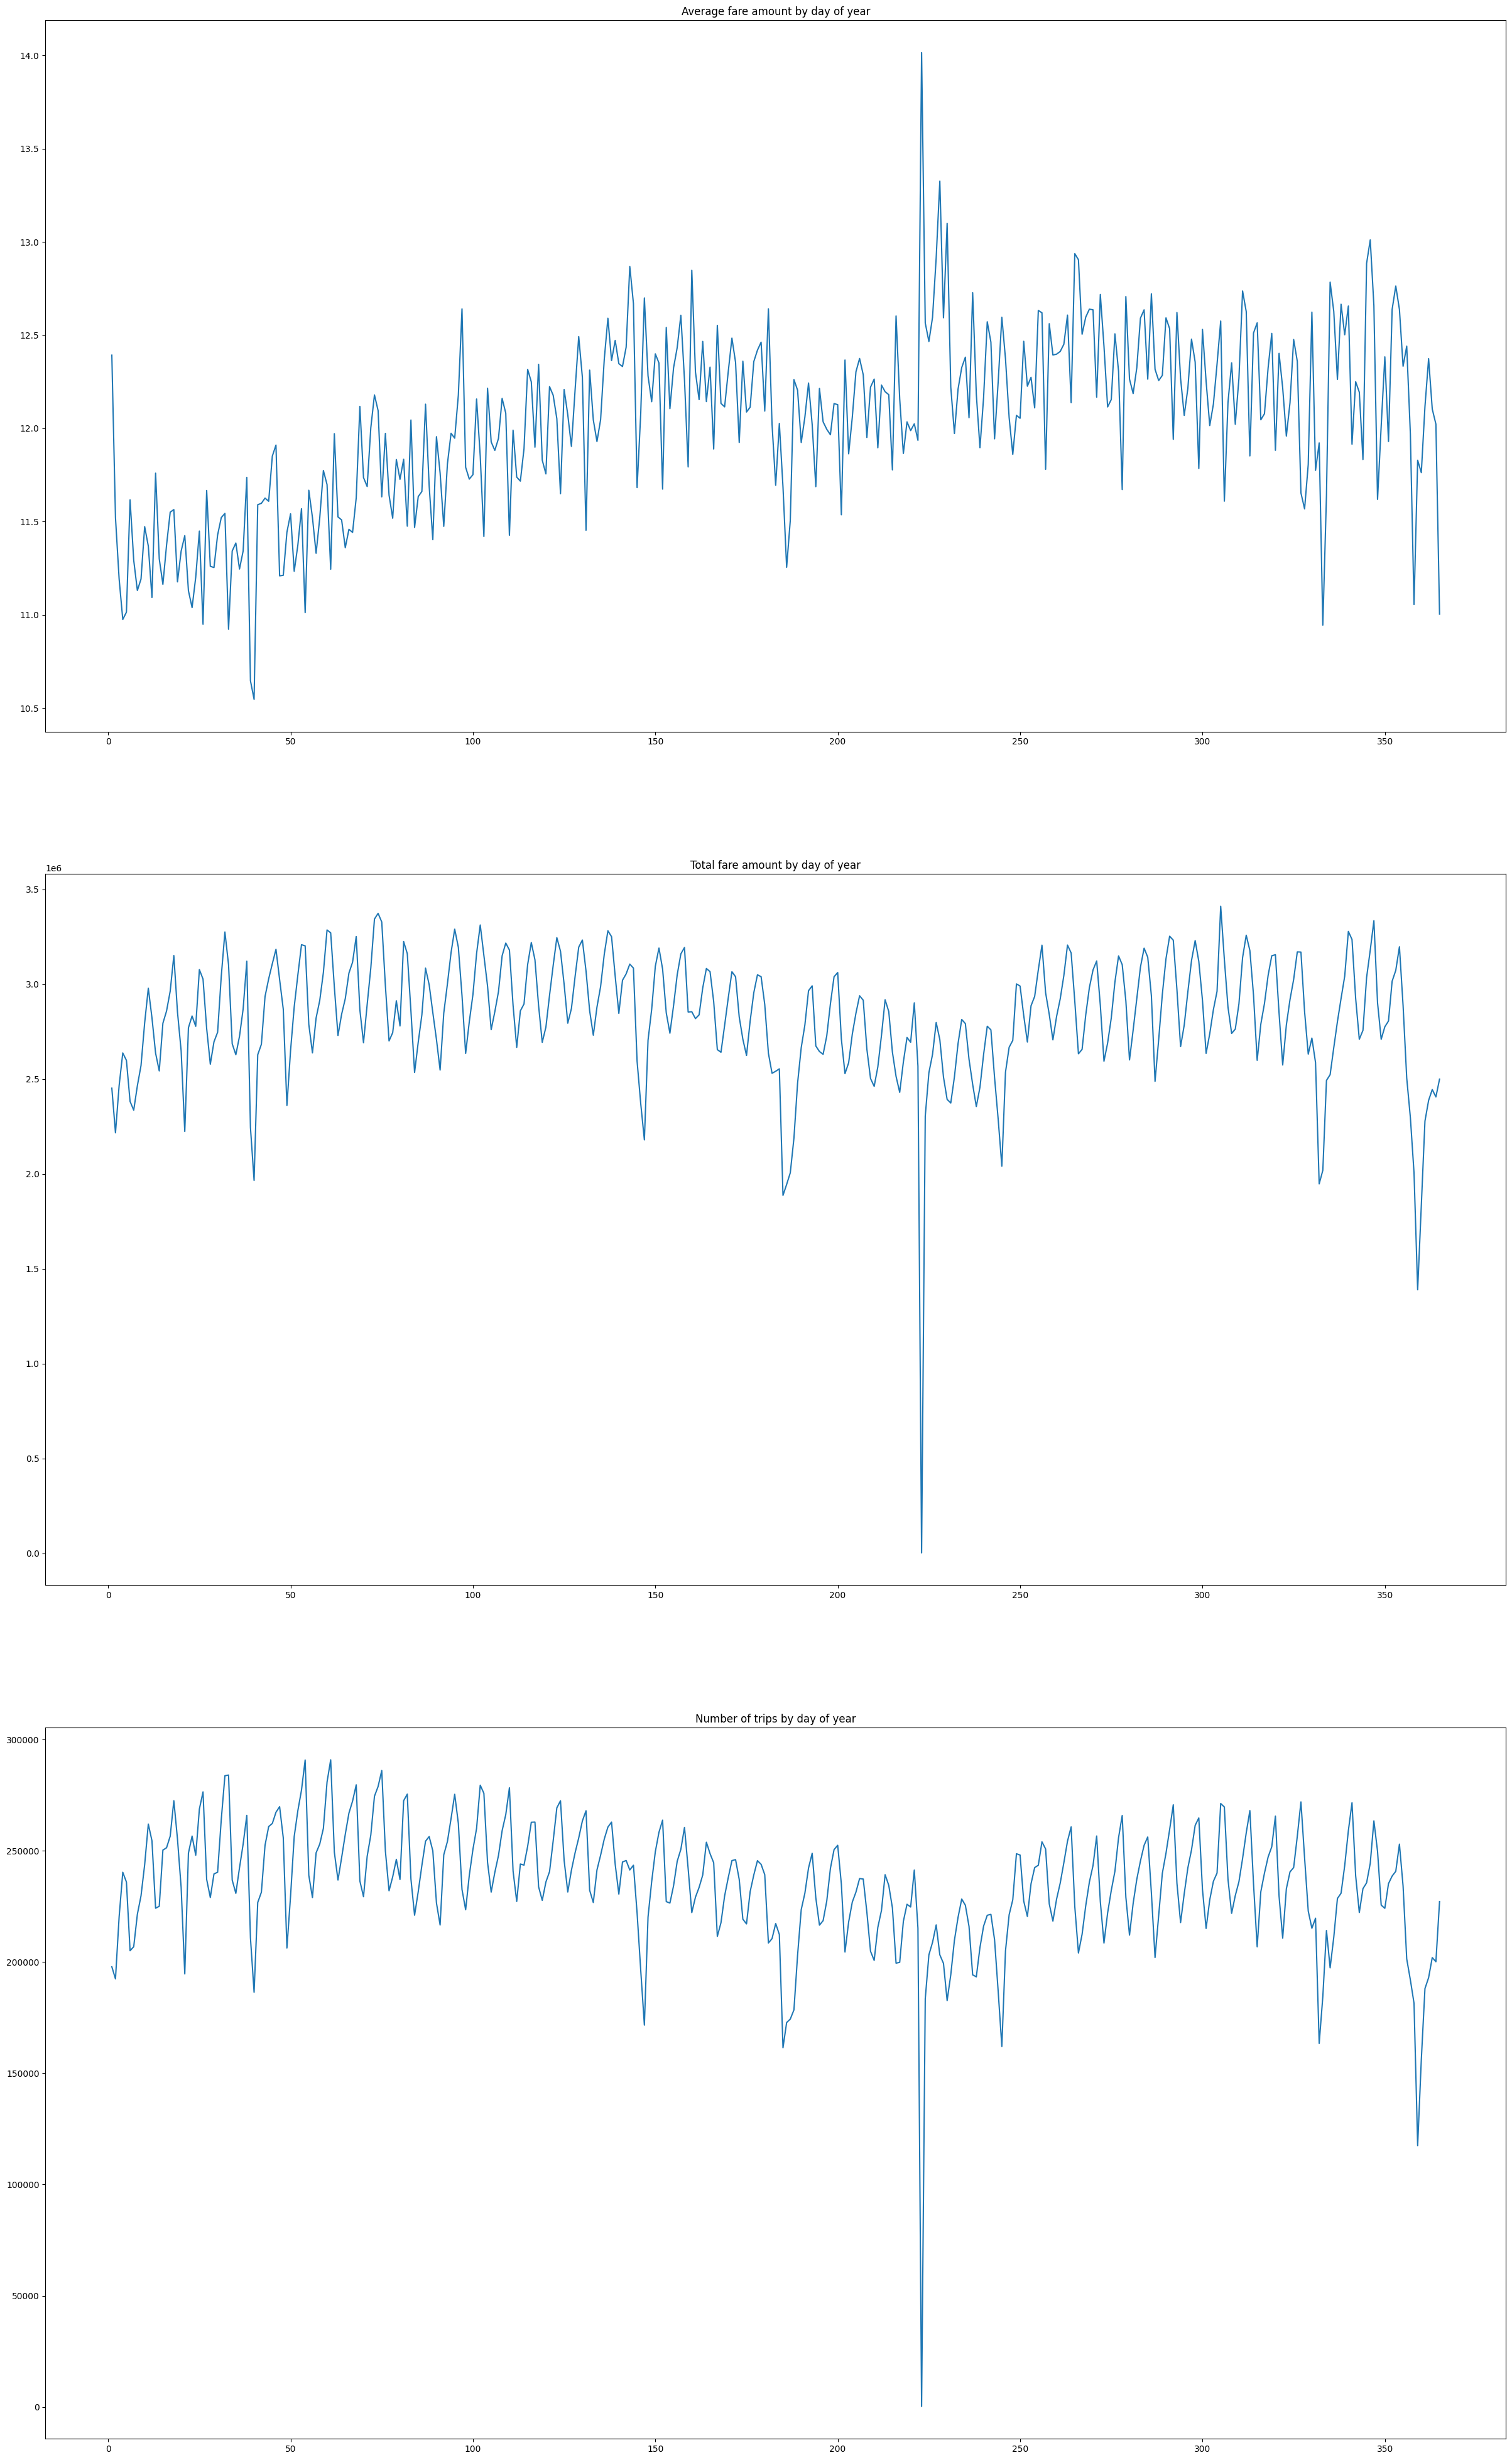

In [359]:
_, ax = plt.subplots(3, figsize=(30, 50))

ax[0].plot(fare_amount_per_day_of_year.dayOfYear, fare_amount_per_day_of_year.fare_amount_avg)
ax[0].set_title('Average fare amount by day of year')

ax[1].plot(fare_amount_per_day_of_year.dayOfYear, fare_amount_per_day_of_year.fare_amount_sum)
ax[1].set_title('Total fare amount by day of year')

ax[2].plot(fare_amount_per_day_of_year.dayOfYear, fare_amount_per_day_of_year.trips_by_day_of_year)
ax[2].set_title('Number of trips by day of year')

In [391]:


Q1_avg = fare_amount_per_day_of_year.fare_amount_avg.quantile(0.25)
Q3_avg = fare_amount_per_day_of_year.fare_amount_avg.quantile(0.75)

IQR_avg = Q3_avg - Q1_avg

lower_bound_avg = Q1_avg - 1.5 * IQR_avg
upper_bound_avg = Q3_avg + 1.5 * IQR_avg

fare_amount_per_day_of_year['is_anomaly_avg'] = (fare_amount_per_day_of_year.fare_amount_avg < lower_bound_avg) | (
        fare_amount_per_day_of_year.fare_amount_avg > upper_bound_avg)

In [394]:

Q1_sum = fare_amount_per_day_of_year.fare_amount_sum.quantile(0.25)
Q3_sum = fare_amount_per_day_of_year.fare_amount_sum.quantile(0.75)

IQR_sum = Q3_sum - Q1_sum
lower_bound_sum = Q1_sum - 1.5 * IQR_sum
upper_bound_sum = Q3_sum + 1.5 * IQR_sum

fare_amount_per_day_of_year['is_anomaly_sum'] = (fare_amount_per_day_of_year.fare_amount_sum < lower_bound_sum) | (
        fare_amount_per_day_of_year.fare_amount_sum > upper_bound_sum)


In [395]:
Q1_count = fare_amount_per_day_of_year.trips_by_day_of_year.quantile(0.25)
Q3_count = fare_amount_per_day_of_year.trips_by_day_of_year.quantile(0.75)

IQR_count = Q3_count - Q1_count
lower_bound_count = Q1_count - 1.5 * IQR_count
upper_bound_count = Q3_count + 1.5 * IQR_count

fare_amount_per_day_of_year['is_anomaly_count'] = (
                                                          fare_amount_per_day_of_year.trips_by_day_of_year < lower_bound_count) | (
                                                          fare_amount_per_day_of_year.trips_by_day_of_year > upper_bound_count)

In [396]:
fare_amount_per_day_of_year

fare_amount_avg  fare_amount_sum  trips_by_day_of_year  \
dayOfYear                                                           
1                12.392739     2.452151e+06                197870   
2                11.521147     2.216761e+06                192408   
3                11.192533     2.465726e+06                220301   
4                10.974997     2.637665e+06                240334   
5                11.014316     2.598773e+06                235945   
...                    ...              ...                   ...   
361              12.117226     2.278766e+06                188060   
362              12.374064     2.387712e+06                192961   
363              12.103771     2.444950e+06                201999   
364              12.022767     2.405912e+06                200113   
365              11.003735     2.499906e+06                227187   

           is_anomaly_avg  is_anomaly_sum  is_anomaly_count  
dayOfYear                                                    
1                   False           False             False  
2                   False           False             False  
3                   False           False             False  
4                   False           False             False  
5                   False           False             False  
...                   ...             ...               ...  
361                 False           False             False  
362                 False           False             False  
363                 False           False             False  
364                 False           False             False  
365                 False           False             False  

[365 rows x 6 columns]

Text(0.5, 1.0, 'Average fare amount by day of year with anomalies')

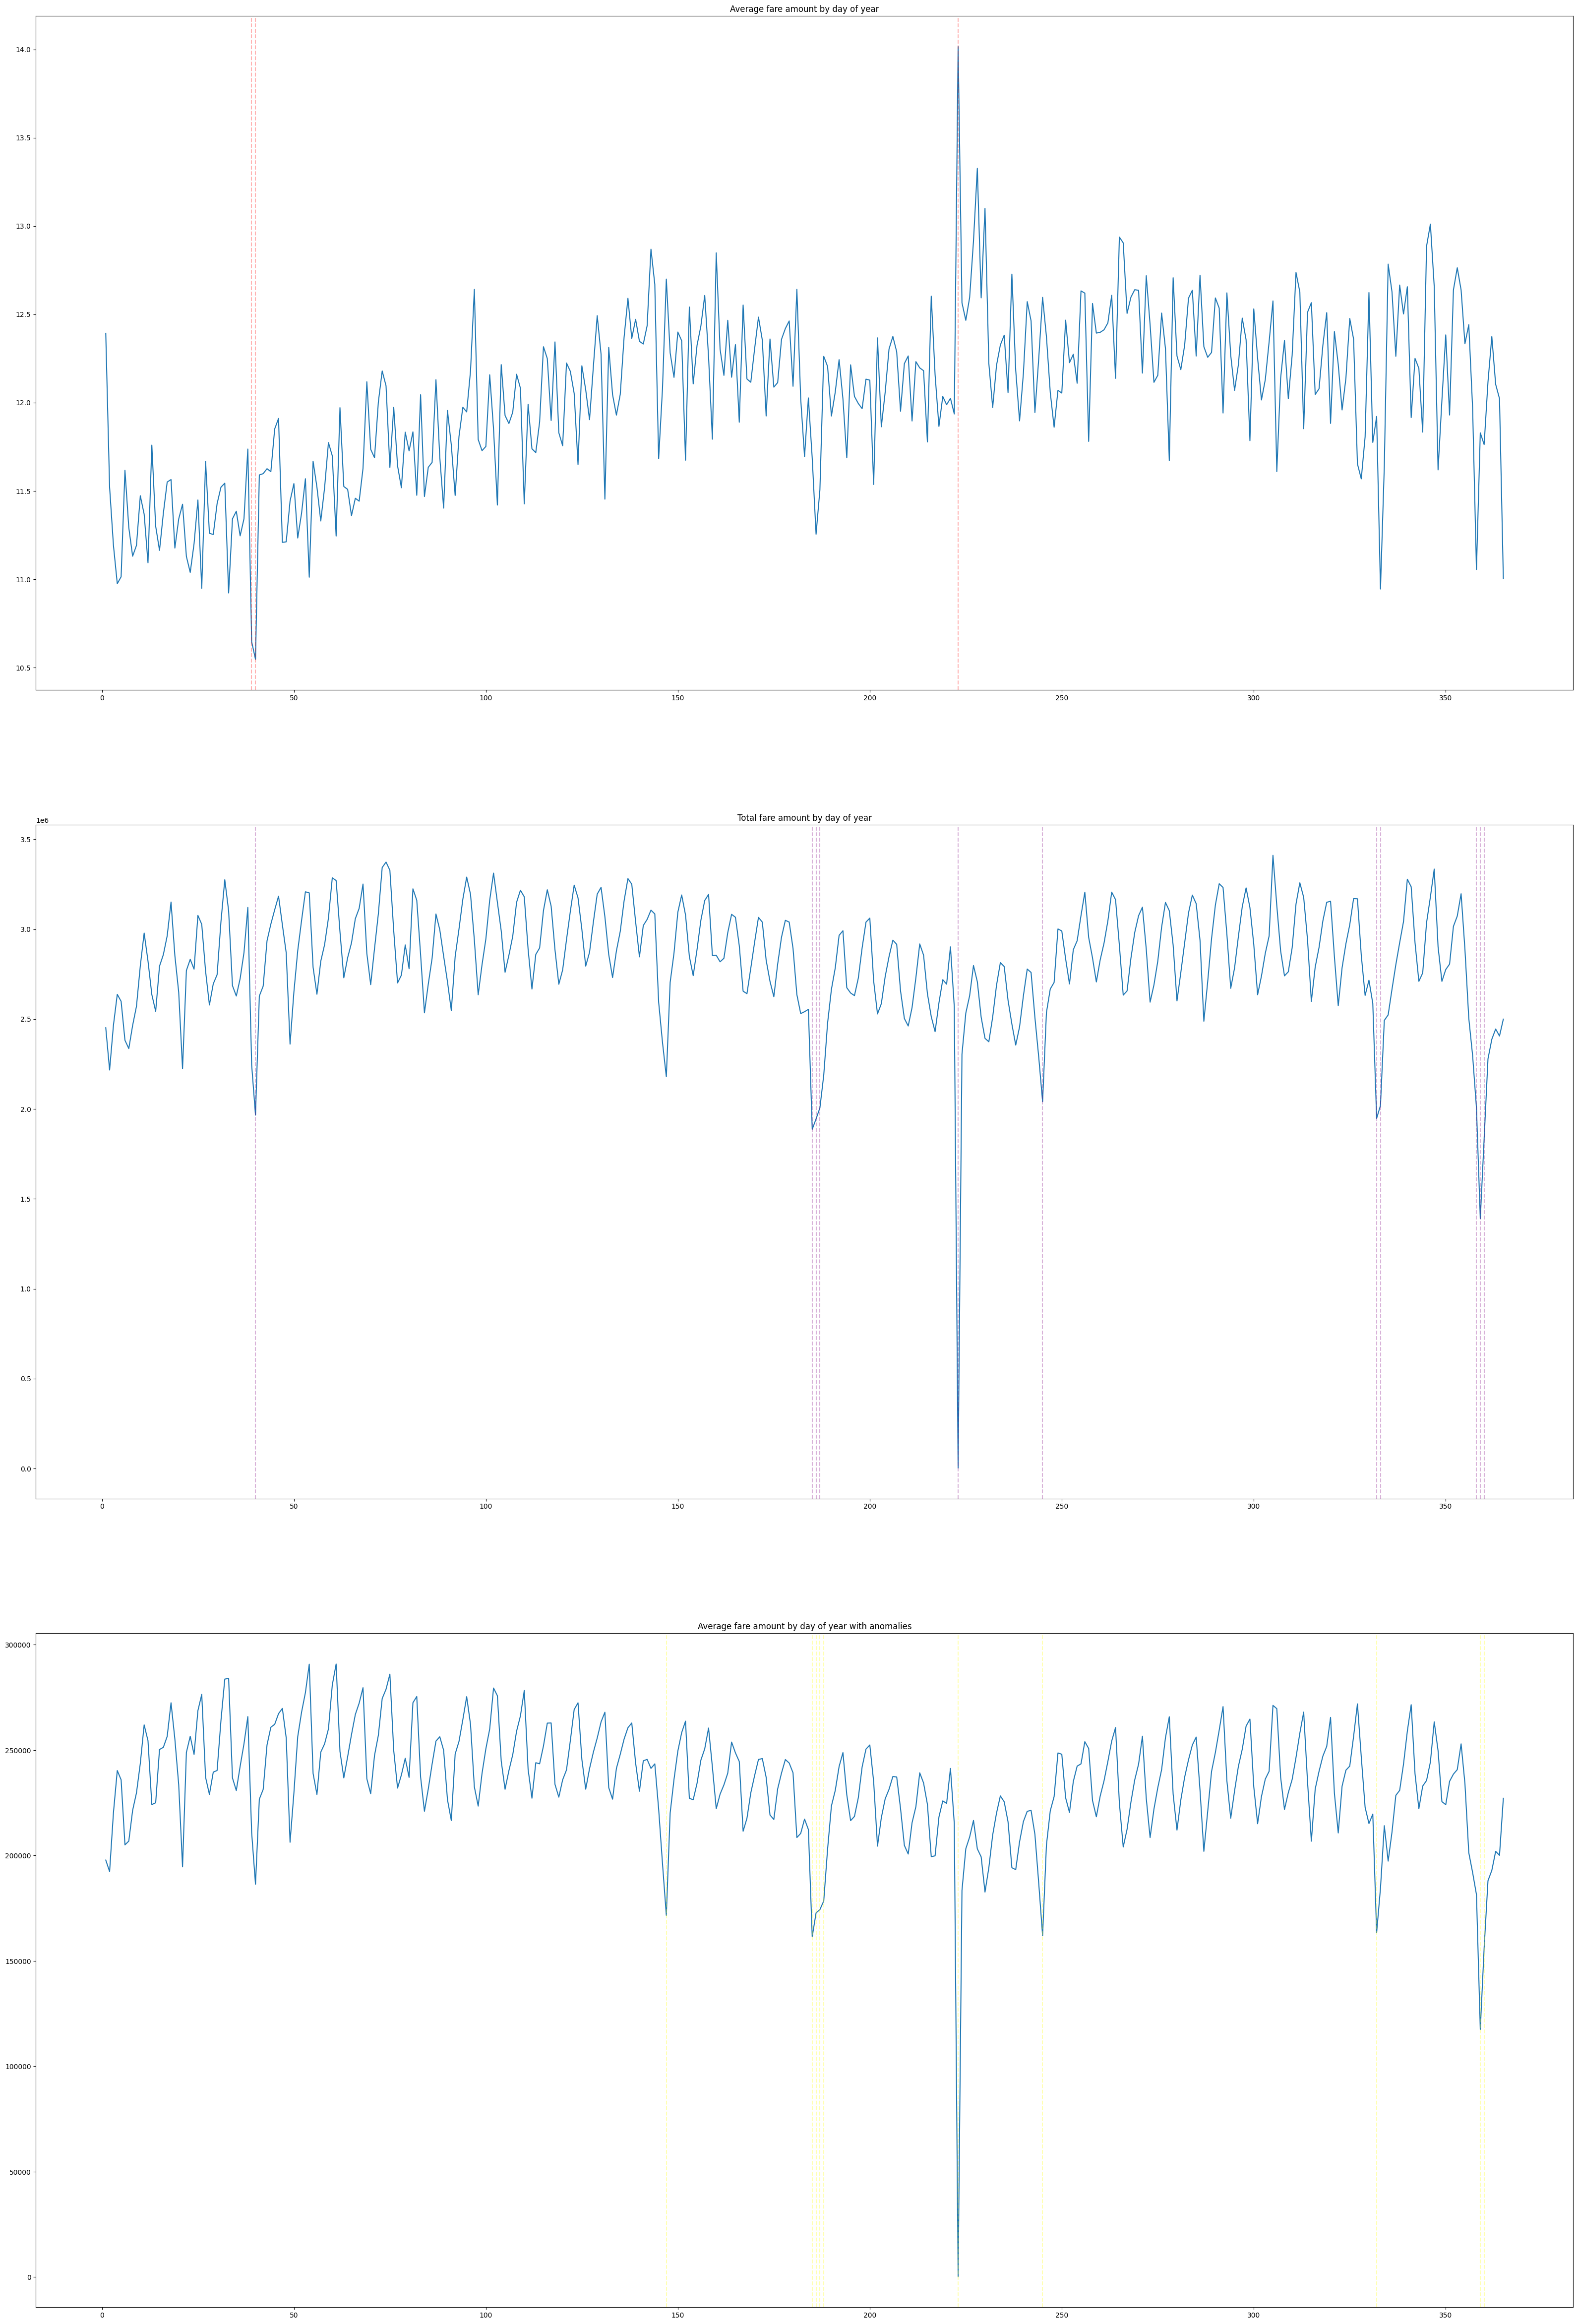

In [399]:
_, ax = plt.subplots(3, figsize=(40, 60))

ax[0].plot(fare_amount_per_day_of_year.index, fare_amount_per_day_of_year.fare_amount_avg)
ax[0].set_title('Average fare amount by day of year')

for idx, row in fare_amount_per_day_of_year[fare_amount_per_day_of_year.is_anomaly_avg].iterrows():
    ax[0].axvline(x=idx, color='red', linestyle='--', alpha=0.3)

ax[1].plot(fare_amount_per_day_of_year.index, fare_amount_per_day_of_year.fare_amount_sum)
ax[1].set_title('Total fare amount by day of year')

for idx, row in fare_amount_per_day_of_year[fare_amount_per_day_of_year.is_anomaly_sum].iterrows():
    ax[1].axvline(x=idx, color='purple', linestyle='--', alpha=0.3)

ax[2].plot(fare_amount_per_day_of_year.index, fare_amount_per_day_of_year.trips_by_day_of_year)
ax[2].set_title('Number of trips by day of year')

for idx, row in fare_amount_per_day_of_year[fare_amount_per_day_of_year.is_anomaly_count].iterrows():
    ax[2].axvline(x=idx, color='yellow', linestyle='--', alpha=0.3)

plt.title('Average fare amount by day of year with anomalies')

In [401]:
fare_amount_per_day_of_year['date'] = pd.to_datetime(fare_amount_per_day_of_year.index, origin='2012-12-31', unit='D')
fare_amount_per_day_of_year

fare_amount_avg  fare_amount_sum  trips_by_day_of_year  \
dayOfYear                                                           
1                12.392739     2.452151e+06                197870   
2                11.521147     2.216761e+06                192408   
3                11.192533     2.465726e+06                220301   
4                10.974997     2.637665e+06                240334   
5                11.014316     2.598773e+06                235945   
...                    ...              ...                   ...   
361              12.117226     2.278766e+06                188060   
362              12.374064     2.387712e+06                192961   
363              12.103771     2.444950e+06                201999   
364              12.022767     2.405912e+06                200113   
365              11.003735     2.499906e+06                227187   

           is_anomaly_avg  is_anomaly_sum  is_anomaly_count       date  
dayOfYear                                                               
1                   False           False             False 2013-01-01  
2                   False           False             False 2013-01-02  
3                   False           False             False 2013-01-03  
4                   False           False             False 2013-01-04  
5                   False           False             False 2013-01-05  
...                   ...             ...               ...        ...  
361                 False           False             False 2013-12-27  
362                 False           False             False 2013-12-28  
363                 False           False             False 2013-12-29  
364                 False           False             False 2013-12-30  
365                 False           False             False 2013-12-31  

[365 rows x 7 columns]

In [409]:
fare_amount_per_day_of_year_indexed = fare_amount_per_day_of_year.set_index('date').drop(
    columns=['fare_amount_avg', 'trips_by_day_of_year', 'is_anomaly_avg', 'is_anomaly_count'])

fare_amount_per_day_of_year_indexed[fare_amount_per_day_of_year_indexed.is_anomaly_sum]

fare_amount_sum  is_anomaly_sum
date                                       
2013-02-09     1.966022e+06            True
2013-07-04     1.887068e+06            True
2013-07-05     1.944813e+06            True
2013-07-06     2.006164e+06            True
2013-08-11     3.167500e+03            True
2013-09-02     2.040897e+06            True
2013-11-28     1.947877e+06            True
2013-11-29     2.019422e+06            True
2013-12-24     2.006459e+06            True
2013-12-25     1.389704e+06            True
2013-12-26     1.836588e+06            True

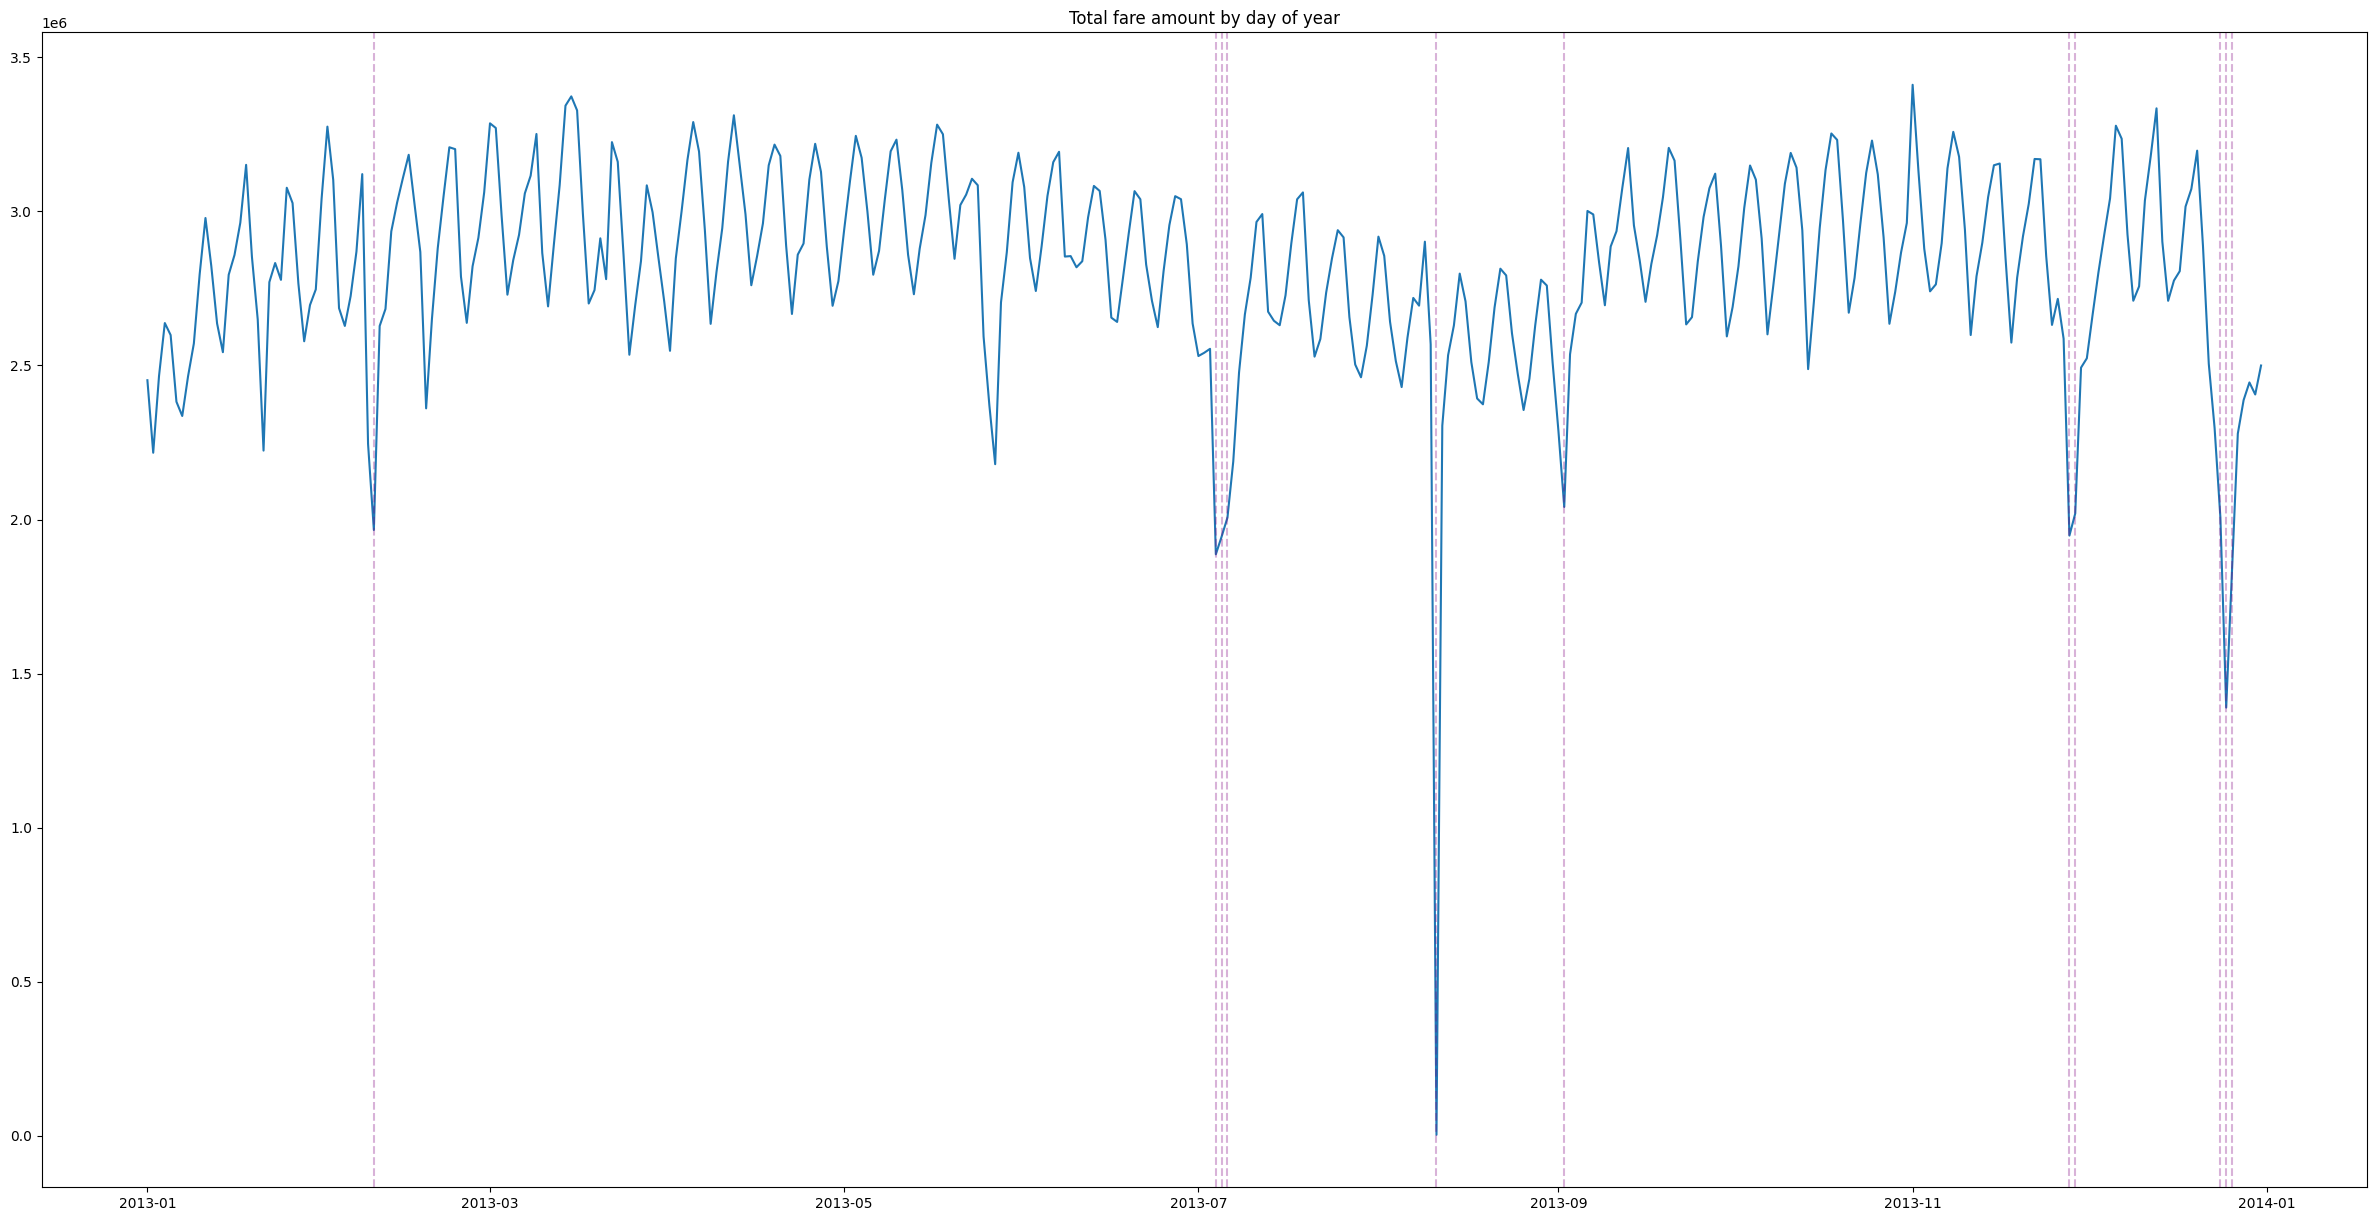

In [413]:
plt.figure(figsize=(30, 15))
plt.plot(fare_amount_per_day_of_year_indexed.index, fare_amount_per_day_of_year_indexed.fare_amount_sum)
plt.title('Total fare amount by day of year')

for idx, row in fare_amount_per_day_of_year_indexed[fare_amount_per_day_of_year_indexed.is_anomaly_sum].iterrows():
    plt.axvline(x=idx, color='purple', linestyle='--', alpha=0.3)

In [686]:
df_wo_anomalies = fare_amount_per_day_of_year_indexed[fare_amount_per_day_of_year_indexed.is_anomaly_sum == False]
df_wo_anomalies


fare_amount_sum  is_anomaly_sum  anomalies_if  day_of_week  \
date                                                                     
2013-01-01     2.452151e+06           False             1            1   
2013-01-02     2.216761e+06           False             1            2   
2013-01-03     2.465726e+06           False             1            3   
2013-01-04     2.637665e+06           False             1            4   
2013-01-05     2.598773e+06           False             1            5   
...                     ...             ...           ...          ...   
2013-12-27     2.278766e+06           False             1            4   
2013-12-28     2.387712e+06           False             1            5   
2013-12-29     2.444950e+06           False             1            6   
2013-12-30     2.405912e+06           False             1            0   
2013-12-31     2.499906e+06           False             1            1   

            dayOfWeek  dayOfYear  
date                              
2013-01-01          1          1  
2013-01-02          2          2  
2013-01-03          3          3  
2013-01-04          4          4  
2013-01-05          5          5  
...               ...        ...  
2013-12-27          4        361  
2013-12-28          5        362  
2013-12-29          6        363  
2013-12-30          0        364  
2013-12-31          1        365  

[354 rows x 6 columns]

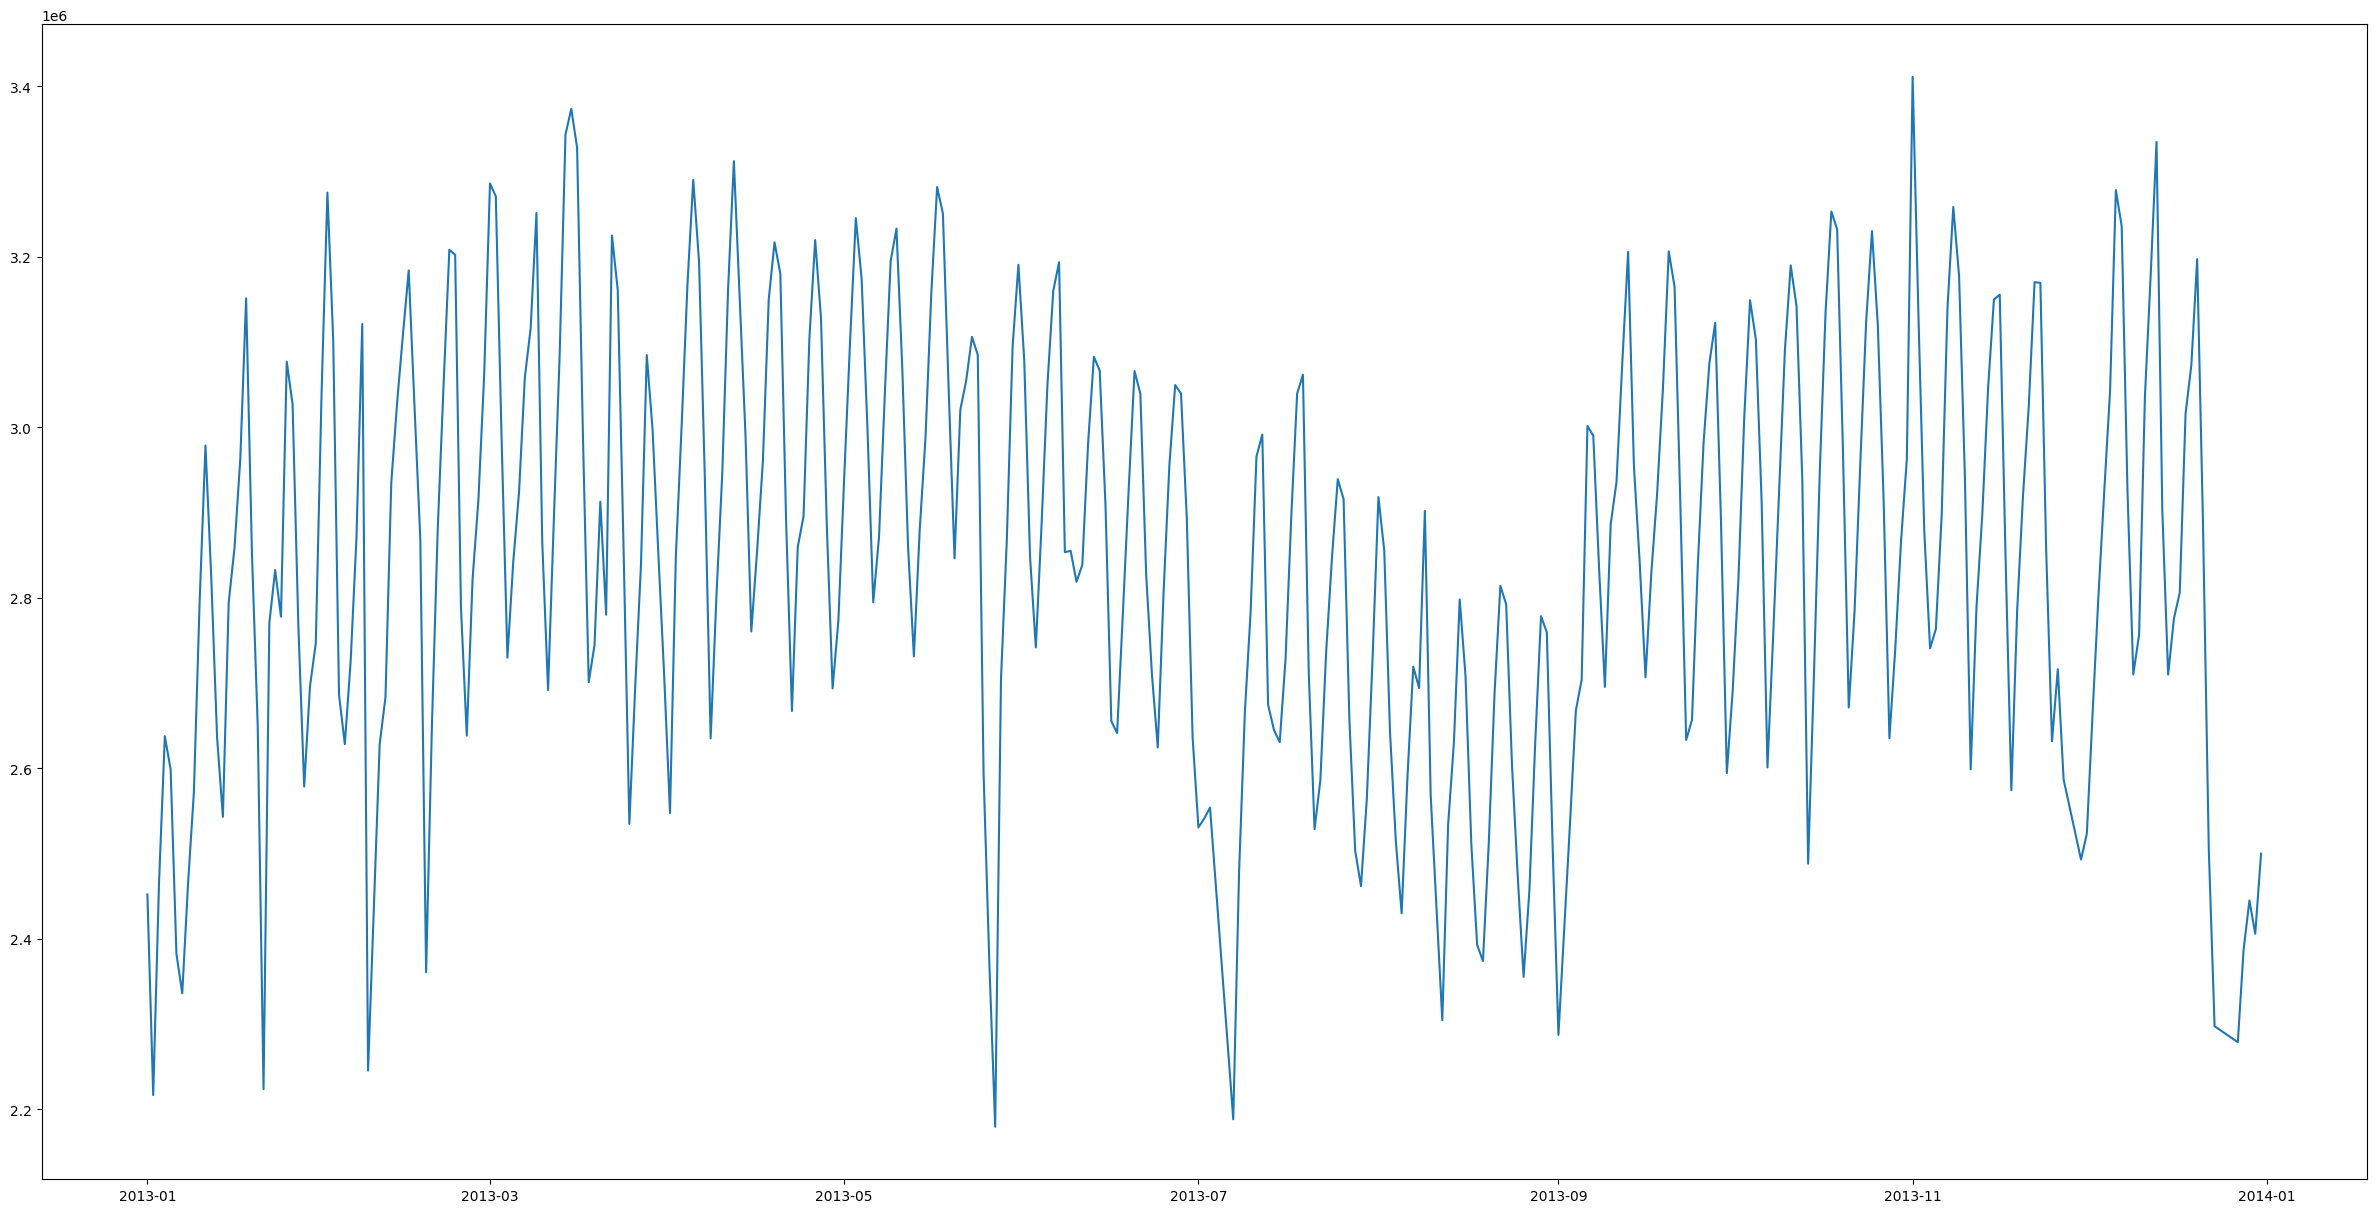

In [692]:
plt.figure(figsize=(30, 15))
plt.plot(df_wo_anomalies.index, df_wo_anomalies.fare_amount_sum)

In [687]:

values = df_wo_anomalies.fare_amount_sum.values
values


array([2452151.21000099, 2216760.90999365, 2465726.20998597,
       2637664.86999512, 2598772.6999979 , 2382308.7099905 ,
       2336069.3299942 , 2464845.24999332, 2571342.04999638,
       2796224.13999844, 2978624.86999989, 2823158.90999651,
       2636261.71000147, 2543113.4699955 , 2794439.64999819,
       2858675.03998661, 2963269.09000063, 3151158.1099956 ,
       2852854.44999886, 2649243.71999931, 2223718.6099987 ,
       2770401.44999743, 2832506.07999325, 2777849.64999628,
       3076838.09999084, 3027063.07000375, 2766372.80999708,
       2578570.92999101, 2696200.06999588, 2746894.25999618,
       3041443.55999947, 3275220.89999294, 3102396.85999775,
       2686106.95999527, 2628348.54999495, 2725362.22000074,
       2869693.81999731, 3121082.2599926 , 2245463.1400001 ,
       2628306.59999847, 2683408.90999508, 2935134.61999345,
       3028486.11999869, 3108217.1400063 , 3183852.54999042,
       3024297.05999899, 2868251.82999849, 2360800.31999588,
       2650786.30999565,

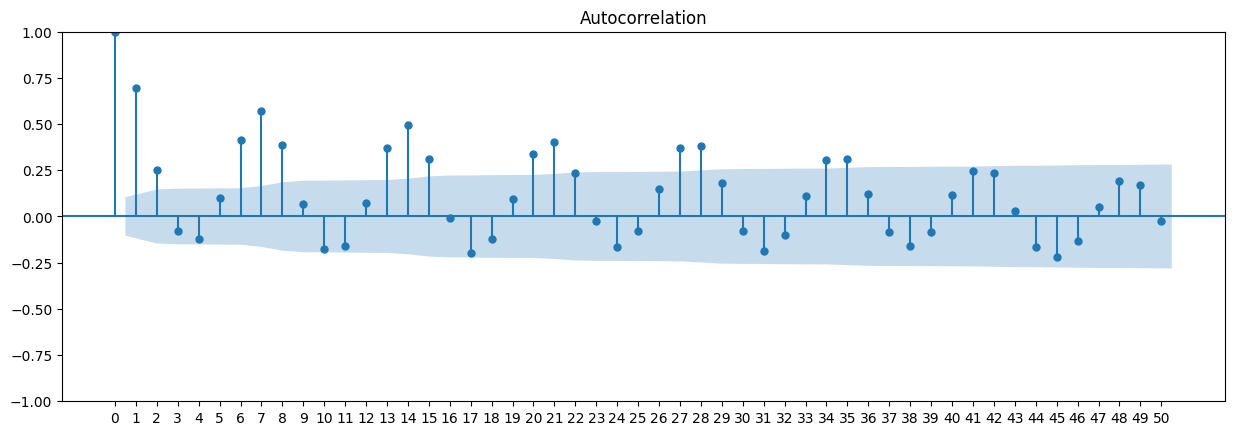

In [688]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig = plot_acf(values, lags=50)
fig.set_figwidth(15)
plt.xticks(range(0, 51, 1))
plt.show()

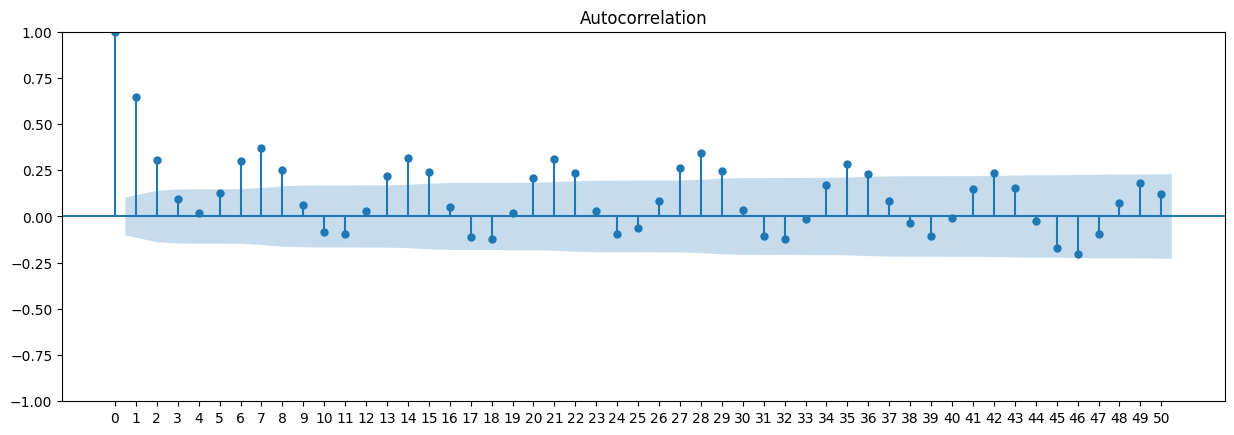

In [447]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

fig = plot_acf(values, lags=50)
fig.set_figwidth(15)
plt.xticks(range(0, 51, 1))
plt.show()

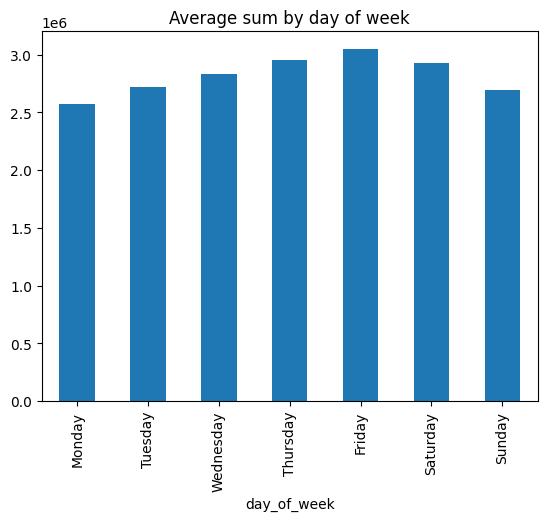

In [452]:
fare_amount_per_day_of_year_indexed['day_of_week'] = fare_amount_per_day_of_year_indexed.index.dayofweek

weekly_pattern = fare_amount_per_day_of_year_indexed.groupby('day_of_week')['fare_amount_sum'].mean()
weekly_pattern.plot(kind='bar', title='Average sum by day of week')
plt.xticks(range(0, 7, 1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

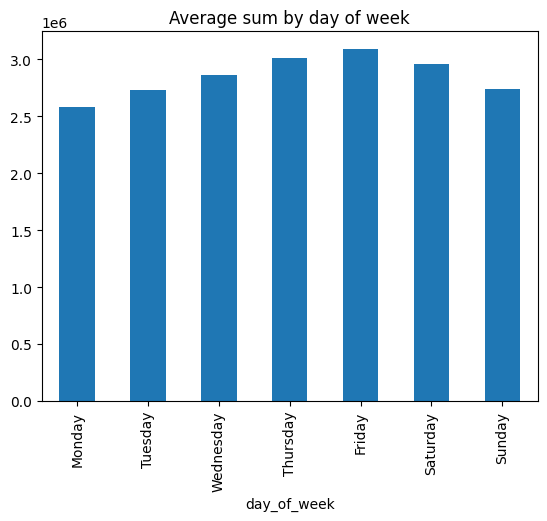

In [689]:
df_wo_anomalies['day_of_week'] = df_wo_anomalies.index.dayofweek

weekly_pattern = df_wo_anomalies.groupby('day_of_week')['fare_amount_sum'].mean()
weekly_pattern.plot(kind='bar', title='Average sum by day of week')
plt.xticks(range(0, 7, 1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

# Прогнозування часових рядів

In [690]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

predict_days = 60
train = df_wo_anomalies.iloc[:-predict_days]
test = df_wo_anomalies.iloc[-predict_days:]
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
m_values = [7]
params = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))
#Akaike Information Criterion
best_aic = float('inf')
best_params = None
best_result = None
for param in params:
    try:
        model = SARIMAX(train.fare_amount_sum,
                        order=param[:3],
                        seasonal_order=param[3:])
        result = model.fit(disp=False)
        if result.aic < best_aic:
            best_result = result
            best_aic = result.aic
            best_params = param
    except:
        continue

Best params: (2, 0, 1, 0, 1, 1, 7)
MAE 242310.40336354382
 MSE 191394345562.60727
 MAPE 0.11260798082812482
 R2 -0.2861714817922463



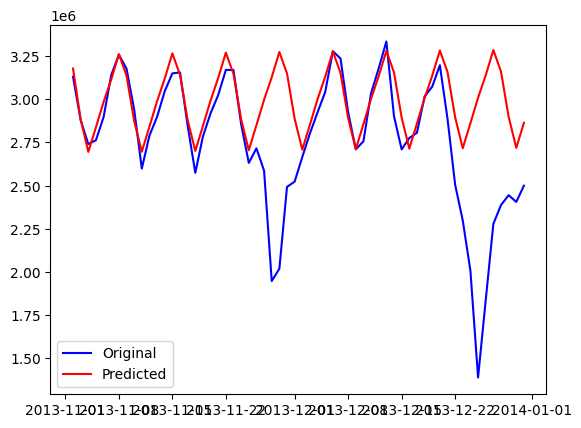

In [498]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print(f"Best params: {best_params}")
forecast = best_result.forecast(steps=predict_days)

mae = mean_absolute_error(test.fare_amount_sum, forecast)
mse = mean_squared_error(test.fare_amount_sum, forecast)
mape = mean_absolute_percentage_error(test.fare_amount_sum, forecast)
r2 = r2_score(test.fare_amount_sum, forecast)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.index, test.fare_amount_sum, color='blue', label='Original')
plt.plot(forecast, color='red', label='Predicted')
plt.legend()
plt.show()

Best params: (0, 1, 0, 1, 1, 1, 7)
MAE 209627.96038322488
 MSE 86599845361.67769
 MAPE 0.07661217470587904
 R2 -0.20051530536438844



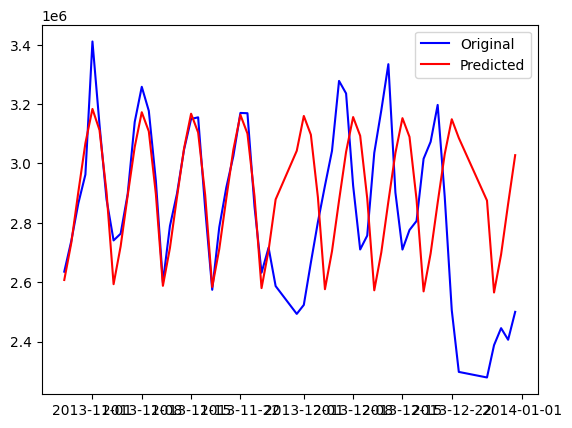

In [694]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

print(f"Best params: {best_params}")
forecast = best_result.forecast(steps=predict_days)

mae = mean_absolute_error(test.fare_amount_sum, forecast)
mse = mean_squared_error(test.fare_amount_sum, forecast)
mape = mean_absolute_percentage_error(test.fare_amount_sum, forecast)
r2 = r2_score(test.fare_amount_sum, forecast)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.index, test.fare_amount_sum, color='blue', label='Original')
plt.plot(test.index,forecast, color='red', label='Predicted')
plt.legend()
plt.show()

00:05:03 - cmdstanpy - INFO - Chain [1] start processing
00:05:03 - cmdstanpy - INFO - Chain [1] done processing


MAE 357255.58704205503
 MSE 293676609465.25195
 MAPE 0.15824394707101863
 R2 -0.9735090859311197



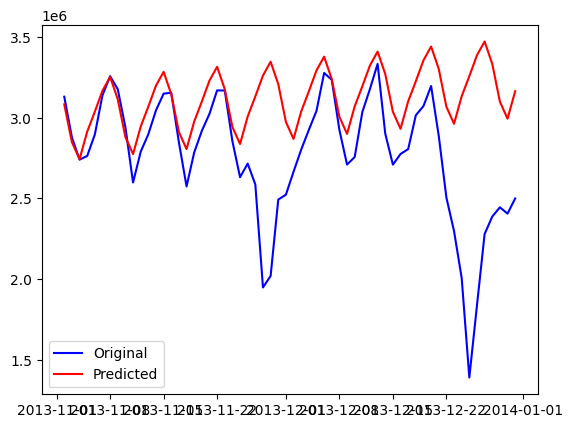

In [510]:
from prophet import Prophet

dataset = pd.DataFrame(
    {'ds': fare_amount_per_day_of_year_indexed.index, 'y': fare_amount_per_day_of_year_indexed.fare_amount_sum}
).reset_index().drop(columns='date')

predict_days = 60
train = dataset.iloc[:-predict_days]
test = dataset.iloc[-predict_days:]

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=predict_days)

forecast = m.predict(future)

pred = forecast.iloc[-predict_days:][['ds', 'yhat']]

mae = mean_absolute_error(test.y, pred.yhat)
mse = mean_squared_error(test.y, pred.yhat)
mape = mean_absolute_percentage_error(test.y, pred.yhat)
r2 = r2_score(test.y, pred.yhat)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.ds, test.y, color='blue', label='Original')
plt.plot(pred.ds, pred.yhat, color='red', label='Predicted')
plt.legend()
plt.show()


01:47:20 - cmdstanpy - INFO - Chain [1] start processing
01:47:21 - cmdstanpy - INFO - Chain [1] done processing


MAE 339177.1659175331
 MSE 209933128012.07968
 MAPE 0.12815701033843188
 R2 -1.9102584678869525



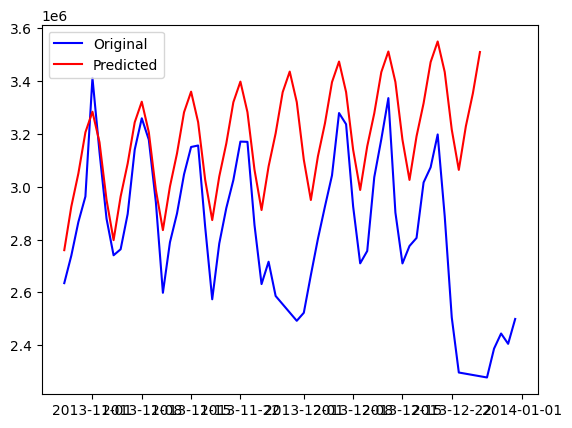

In [695]:
from prophet import Prophet

dataset = pd.DataFrame(
    {'ds': df_wo_anomalies.index, 'y': df_wo_anomalies.fare_amount_sum}
).reset_index().drop(columns='date')

predict_days = 60
train = dataset.iloc[:-predict_days]
test = dataset.iloc[-predict_days:]

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=predict_days)

forecast = m.predict(future)

pred = forecast.iloc[-predict_days:][['ds', 'yhat']]

mae = mean_absolute_error(test.y, pred.yhat)
mse = mean_squared_error(test.y, pred.yhat)
mape = mean_absolute_percentage_error(test.y, pred.yhat)
r2 = r2_score(test.y, pred.yhat)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.ds, test.y, color='blue', label='Original')
plt.plot(pred.ds, pred.yhat, color='red', label='Predicted')
plt.legend()
plt.show()

[0]	validation_0-rmse:0.11462
[1000]	validation_0-rmse:0.11371
[2000]	validation_0-rmse:0.11314
[3000]	validation_0-rmse:0.11286
[4000]	validation_0-rmse:0.11272
[4885]	validation_0-rmse:0.11268
MAE 251193.415334026
 MSE 147454707812.0942
 MAPE 0.10971513270287869
 R2 0.009103223575188779



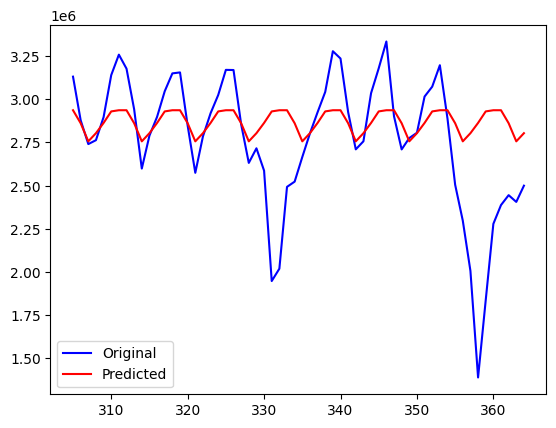

In [571]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
def create_features(df: pd.DataFrame):
    df['dayOfWeek'] = df.index.dayofweek
    df['dayOfYear'] = df.index.dayofyear
    return df
df_features = create_features(fare_amount_per_day_of_year_indexed)
FEATURES = ['dayOfWeek', 'dayOfYear']
TARGET = 'fare_amount_sum'
predict_days = 60
x = df_features[FEATURES]
y = df_features[TARGET]
scaler = MinMaxScaler()
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)))
x_train, x_test = x.iloc[:-predict_days], x.iloc[-predict_days:]
y_train, y_test = pd.DataFrame(y.iloc[:-predict_days]), pd.DataFrame(y.iloc[-predict_days:])
reg = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=100, learning_rate=0.0001)
reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=1000)
y_test['prediction'] = reg.predict(x_test)
y_test['y'] = scaler.inverse_transform(y_test[0].values.reshape(-1, 1))
y_test['prediction'] = scaler.inverse_transform(y_test.prediction.values.reshape(-1, 1))

mae = mean_absolute_error(y_test.y, y_test.prediction)
mse = mean_squared_error(y_test.y, y_test.prediction)
mape = mean_absolute_percentage_error(y_test.y, y_test.prediction)
r2 = r2_score(y_test.y, y_test.prediction)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(y_test.index, y_test.y, color='blue', label='Original')
plt.plot(y_test.index, y_test.prediction, color='red', label='Predicted')
plt.legend()
plt.show()

[0]	validation_0-rmse:0.21815
[1000]	validation_0-rmse:0.20973
[2000]	validation_0-rmse:0.20339
[3000]	validation_0-rmse:0.19815
[4000]	validation_0-rmse:0.19383
[5000]	validation_0-rmse:0.19047
[6000]	validation_0-rmse:0.18791
[7000]	validation_0-rmse:0.18591
[8000]	validation_0-rmse:0.18405
[9000]	validation_0-rmse:0.18227
[10000]	validation_0-rmse:0.18072
[11000]	validation_0-rmse:0.17948
[12000]	validation_0-rmse:0.17840
[13000]	validation_0-rmse:0.17746
[14000]	validation_0-rmse:0.17712
[15000]	validation_0-rmse:0.17690
[15206]	validation_0-rmse:0.17689
MAE 143727.92233405114
 MSE 47449005714.650894
 MAPE 0.05352781450456918
 R2 0.3422244884288418



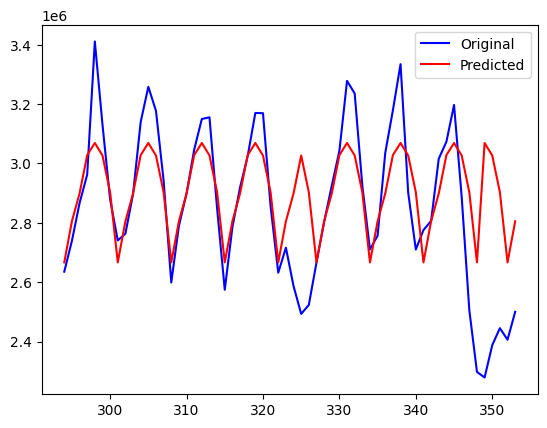

In [698]:
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler


def create_features(df: pd.DataFrame):
    df['dayOfWeek'] = df.index.dayofweek
    df['dayOfYear'] = df.index.dayofyear
    return df


df_features = create_features(df_wo_anomalies)

FEATURES = ['dayOfWeek', 'dayOfYear']
TARGET = 'fare_amount_sum'
predict_days = 60

x = df_features[FEATURES]
y = df_features[TARGET]

scaler = MinMaxScaler()
y = pd.DataFrame(scaler.fit_transform(y.values.reshape(-1, 1)))

x_train, x_test = x.iloc[:-predict_days], x.iloc[-predict_days:]
y_train, y_test = pd.DataFrame(y.iloc[:-predict_days]), pd.DataFrame(y.iloc[-predict_days:])

reg = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=100, learning_rate=0.0001)
reg.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=1000)

y_test['prediction'] = reg.predict(x_test)
y_test['y'] = scaler.inverse_transform(y_test[0].values.reshape(-1, 1))
y_test['prediction'] = scaler.inverse_transform(y_test.prediction.values.reshape(-1, 1))

mae = mean_absolute_error(y_test.y, y_test.prediction)
mse = mean_squared_error(y_test.y, y_test.prediction)
mape = mean_absolute_percentage_error(y_test.y, y_test.prediction)
r2 = r2_score(y_test.y, y_test.prediction)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(y_test.index, y_test.y, color='blue', label='Original')
plt.plot(y_test.index, y_test.prediction, color='red', label='Predicted')
plt.legend()
plt.show()

MAE 482858.64649573964
 MSE 417552338970.27277
 MAPE 0.20576809021085765
 R2 -1.8059549458504818



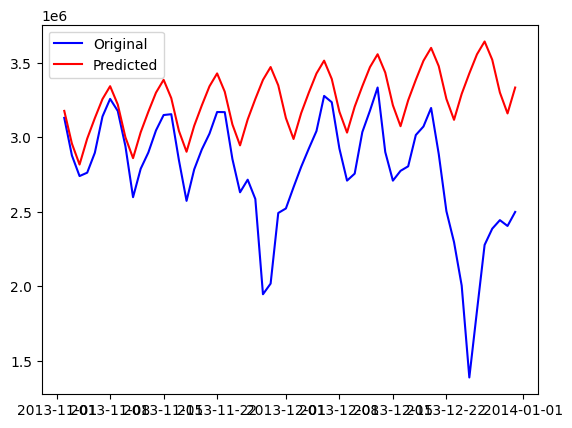

In [534]:
from neuralprophet import NeuralProphet

dataset = pd.DataFrame(
    {'ds': fare_amount_per_day_of_year_indexed.index, 'y': fare_amount_per_day_of_year_indexed.fare_amount_sum}
).reset_index().drop(columns='date')

predict_days = 60
train = dataset.iloc[:-predict_days]
test = dataset.iloc[-predict_days:]

m = NeuralProphet()
m.fit(train)

future = m.make_future_dataframe(train, periods=predict_days)

forecast = m.predict(future)

pred = forecast.iloc[-predict_days:][['ds', 'yhat1']]

mae = mean_absolute_error(test.y, pred.yhat1)
mse = mean_squared_error(test.y, pred.yhat1)
mape = mean_absolute_percentage_error(test.y, pred.yhat1)
r2 = r2_score(test.y, pred.yhat1)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.ds, test.y, color='blue', label='Original')
plt.plot(pred.ds, pred.yhat1, color='red', label='Predicted')
plt.legend()
plt.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.299% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 170


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (19) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.


Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.299% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


MAE 362352.66816316446
 MSE 231301612869.04938
 MAPE 0.13664225161399898
 R2 -2.206485245384079



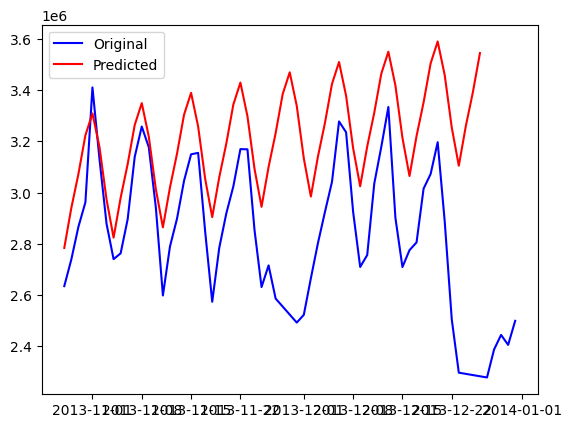

In [699]:
from neuralprophet import NeuralProphet

dataset = pd.DataFrame(
    {'ds': df_wo_anomalies.index, 'y': df_wo_anomalies.fare_amount_sum}
).reset_index().drop(columns='date')

predict_days = 60
train = dataset.iloc[:-predict_days]
test = dataset.iloc[-predict_days:]

m = NeuralProphet()
m.fit(train)

future = m.make_future_dataframe(train, periods=predict_days)

forecast = m.predict(future)

pred = forecast.iloc[-predict_days:][['ds', 'yhat1']]

mae = mean_absolute_error(test.y, pred.yhat1)
mse = mean_squared_error(test.y, pred.yhat1)
mape = mean_absolute_percentage_error(test.y, pred.yhat1)
r2 = r2_score(test.y, pred.yhat1)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.plot(test.ds, test.y, color='blue', label='Original')
plt.plot(pred.ds, pred.yhat1, color='red', label='Predicted')
plt.legend()
plt.show()

In [738]:
df_lstm = pd.DataFrame({'y': fare_amount_per_day_of_year_indexed.copy()['fare_amount_sum']})
values = df_lstm.values
scaler = MinMaxScaler()
values_norm = scaler.fit_transform(values)
values_norm

array([[0.71862728],
       [0.64955459],
       [0.72261072],
       [0.77306422],
       [0.76165174],
       [0.69813277],
       [0.68456433],
       [0.72235221],
       [0.75360252],
       [0.81959169],
       [0.87311518],
       [0.8274954 ],
       [0.77265248],
       [0.74531916],
       [0.81906805],
       [0.83791722],
       [0.86860919],
       [0.92374316],
       [0.83620923],
       [0.77646191],
       [0.65159625],
       [0.81201431],
       [0.83023823],
       [0.8141999 ],
       [0.90193477],
       [0.88732883],
       [0.81083215],
       [0.75572376],
       [0.79024073],
       [0.80511638],
       [0.89154863],
       [0.96014801],
       [0.9094347 ],
       [0.78727902],
       [0.77033045],
       [0.79879804],
       [0.84115056],
       [0.91491773],
       [0.65797695],
       [0.57597808],
       [0.77031814],
       [0.78648731],
       [0.86035344],
       [0.88774641],
       [0.9111426 ],
       [0.93333698],
       [0.88651718],
       [0.840

In [700]:
df_lstm_wo_anomalies = pd.DataFrame({'y': df_wo_anomalies.copy()['fare_amount_sum']})
values_wo_anomalies = df_lstm_wo_anomalies.values
scaler = MinMaxScaler()
values_wo_anomalies = scaler.fit_transform(values_wo_anomalies)
values_wo_anomalies

array([[0.22132892],
       [0.03017711],
       [0.23235268],
       [0.37197775],
       [0.34039485],
       [0.16461239],
       [0.12706309],
       [0.23163729],
       [0.31811943],
       [0.50073791],
       [0.64885884],
       [0.52261065],
       [0.3708383 ],
       [0.29519603],
       [0.49928879],
       [0.55145199],
       [0.63638898],
       [0.78896675],
       [0.5467253 ],
       [0.38138051],
       [0.0358272 ],
       [0.47976825],
       [0.53020114],
       [0.48581666],
       [0.7286142 ],
       [0.68819372],
       [0.47649674],
       [0.32398973],
       [0.41951204],
       [0.46067893],
       [0.69987159],
       [0.88971358],
       [0.74936953],
       [0.41131579],
       [0.36441231],
       [0.44319355],
       [0.56039994],
       [0.76454326],
       [0.05348513],
       [0.36437824],
       [0.40912481],
       [0.61354201],
       [0.68934933],
       [0.75409596],
       [0.8155167 ],
       [0.68594755],
       [0.55922895],
       [0.147

In [739]:
def create_dataset(data, window=10):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:(i + window), 0])
        y.append(data[i + window, 0])
    return np.array(x), np.array(y)
window = 7
x, y = create_dataset(values_norm, window)
x = x.reshape((x.shape[0], x.shape[1], 1))
x

array([[[0.71862728],
        [0.64955459],
        [0.72261072],
        ...,
        [0.76165174],
        [0.69813277],
        [0.68456433]],

       [[0.64955459],
        [0.72261072],
        [0.77306422],
        ...,
        [0.69813277],
        [0.68456433],
        [0.72235221]],

       [[0.72261072],
        [0.77306422],
        [0.76165174],
        ...,
        [0.68456433],
        [0.72235221],
        [0.75360252]],

       ...,

       [[0.73426814],
        [0.67325222],
        [0.58784372],
        ...,
        [0.53799718],
        [0.66774919],
        [0.69971821]],

       [[0.67325222],
        [0.58784372],
        [0.40686386],
        ...,
        [0.66774919],
        [0.69971821],
        [0.71651409]],

       [[0.58784372],
        [0.40686386],
        [0.53799718],
        ...,
        [0.69971821],
        [0.71651409],
        [0.70505891]]])

In [747]:
import numpy as np


def create_dataset(data, window=10):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:(i + window), 0])
        y.append(data[i + window, 0])
    return np.array(x), np.array(y)


window = 7
x, y = create_dataset(values_wo_anomalies, window)
x = x.reshape((x.shape[0], x.shape[1], 1))
x

array([[[0.22132892],
        [0.03017711],
        [0.23235268],
        ...,
        [0.34039485],
        [0.16461239],
        [0.12706309]],

       [[0.03017711],
        [0.23235268],
        [0.37197775],
        ...,
        [0.16461239],
        [0.12706309],
        [0.23163729]],

       [[0.23235268],
        [0.37197775],
        [0.34039485],
        ...,
        [0.12706309],
        [0.23163729],
        [0.31811943]],

       ...,

       [[0.72551894],
        [0.82636959],
        [0.57515384],
        ...,
        [0.09575794],
        [0.08052884],
        [0.16899995]],

       [[0.82636959],
        [0.57515384],
        [0.26461343],
        ...,
        [0.08052884],
        [0.16899995],
        [0.21548086]],

       [[0.57515384],
        [0.26461343],
        [0.09575794],
        ...,
        [0.16899995],
        [0.21548086],
        [0.1837798 ]]])

In [748]:
days_to_predict = 60
valid_length = 30
x_train, x_test = x[:-days_to_predict], x[-days_to_predict:]
y_train, y_test = y[:-days_to_predict], y[-days_to_predict:]
x_train, x_val = x_train[:-valid_length], x_train[-valid_length:]
y_train, y_val = y_train[:-valid_length], y_train[-valid_length:]
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((257, 7, 1), (30, 7, 1), (60, 7, 1), (257,), (30,), (60,))

In [741]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

lstm = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
history = lstm.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)],
                   verbose=1)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.9535 - val_loss: 0.7490 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2284 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6490 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4077 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0998 - val_loss: 0.3453 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0844 - val_loss: 0.3436 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8532 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8286 - val_loss: 0.3213 - learning_rate: 0.0010
Epoch 9/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8446 - val_loss: 0.3174 - learning_rate: 0.0010
E

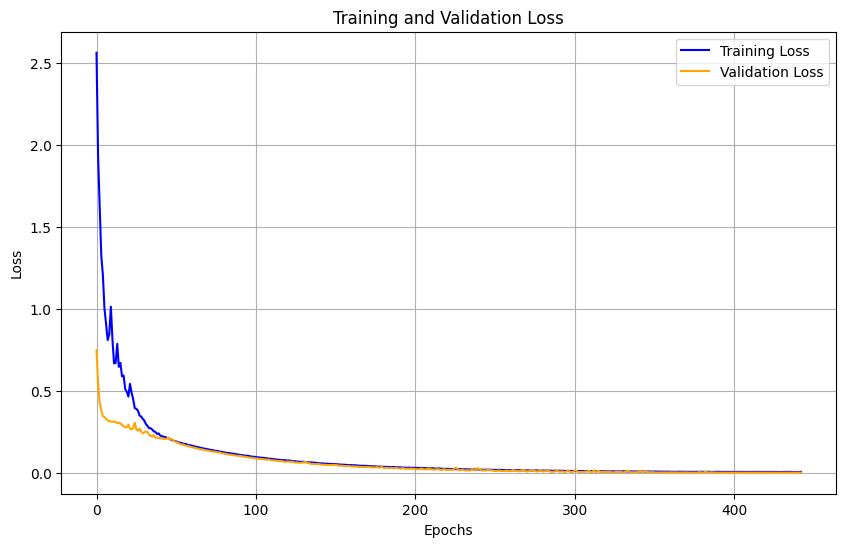

In [742]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
MAE 169440.7576672872
 MSE 74534796102.18066
 MAPE 0.0744760369818107
 R2 0.49912559398748657



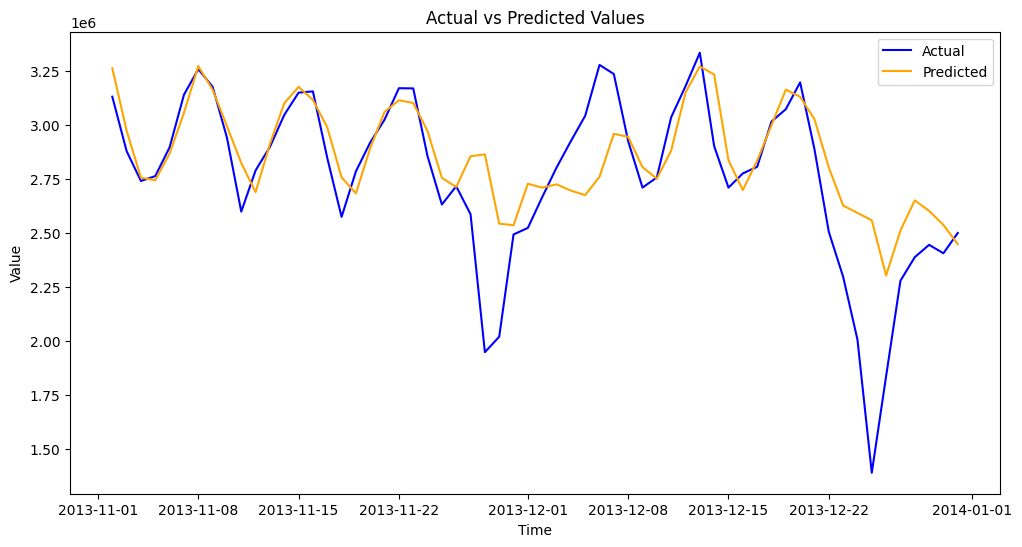

In [743]:
from sklearn.metrics import mean_squared_error

y_pred = lstm.predict(x_test)
y_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

mae = mean_absolute_error(y_inv, y_pred)
mse = mean_squared_error(y_inv, y_pred)
mape = mean_absolute_percentage_error(y_inv, y_pred)
r2 = r2_score(y_inv, y_pred)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[-len(y_test):], y_inv, label="Actual", color="blue")
plt.plot(df_lstm.index[-len(y_test):], y_pred, label="Predicted", color="orange")
plt.title("Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [749]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

lstm = Sequential([
    LSTM(256, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

lstm.compile(optimizer='adam', loss='mse')

history = lstm.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)],
                   verbose=1)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 4.7209 - val_loss: 0.5384 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8282 - val_loss: 0.4293 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3591 - val_loss: 0.3912 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6452 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7023 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3409 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2294 - val_loss: 0.3641 - learning_rate: 0.0010
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2673 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 9/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0643 - val_loss: 0.3676 - learning_rate: 0.0010
Epo

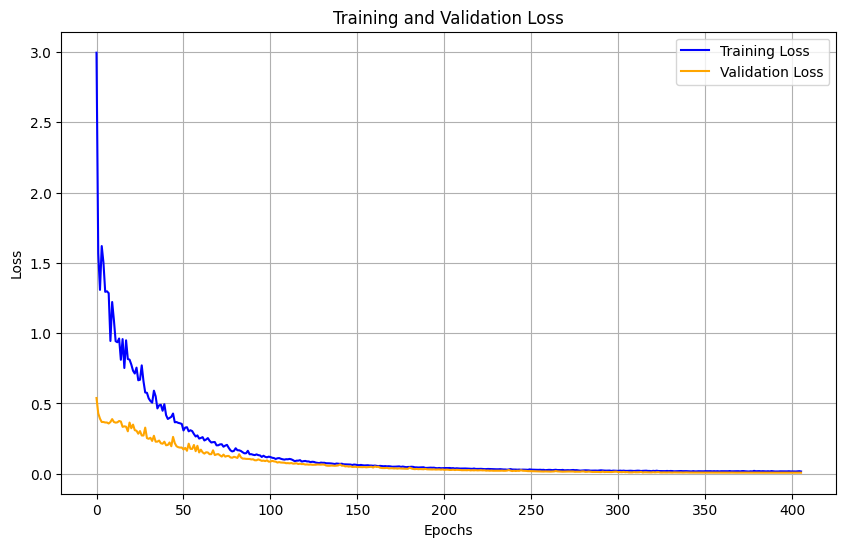

In [750]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
MAE 283264.72457509825
 MSE 158025110589.96857
 MAPE 0.25766422890082796
 R2 0.7139561805668937



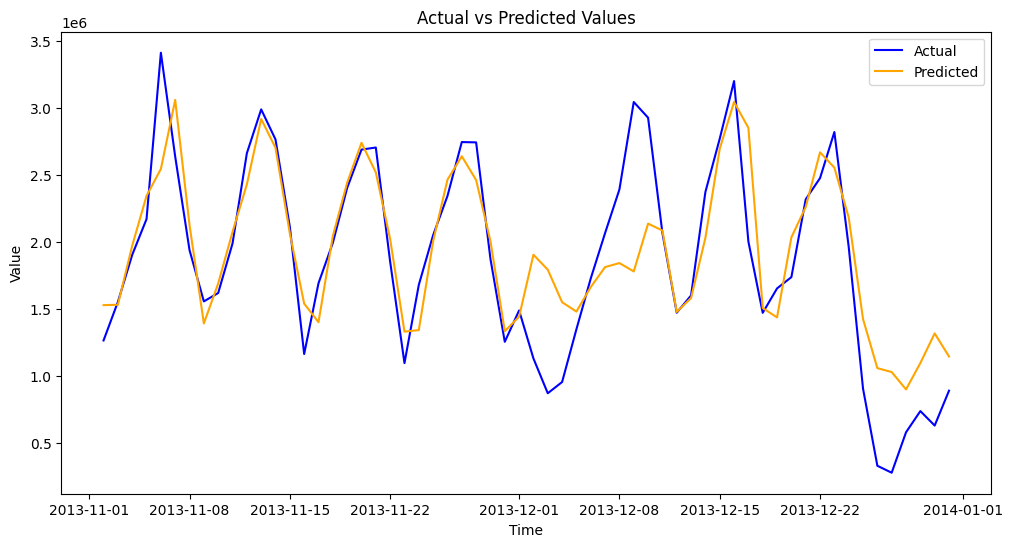

In [751]:
from sklearn.metrics import mean_squared_error

y_pred = lstm.predict(x_test)
y_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

mae = mean_absolute_error(y_inv, y_pred)
mse = mean_squared_error(y_inv, y_pred)
mape = mean_absolute_percentage_error(y_inv, y_pred)
r2 = r2_score(y_inv, y_pred)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[-len(y_test):], y_inv, label="Actual", color="blue")
plt.plot(df_lstm.index[-len(y_test):], y_pred, label="Predicted", color="orange")
plt.title("Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [744]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

gru = Sequential([
    GRU(256, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

gru.compile(optimizer='adam', loss='mse')

history = gru.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)],
                   verbose=1)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 3.1680 - val_loss: 0.8566 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1071 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7437 - val_loss: 0.3678 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1754 - val_loss: 0.3317 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0939 - val_loss: 0.3043 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2264 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8351 - val_loss: 0.3201 - learning_rate: 0.0010
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9132 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 9/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7466 - val_loss: 0.3442 - learning_rate: 0.0010
E

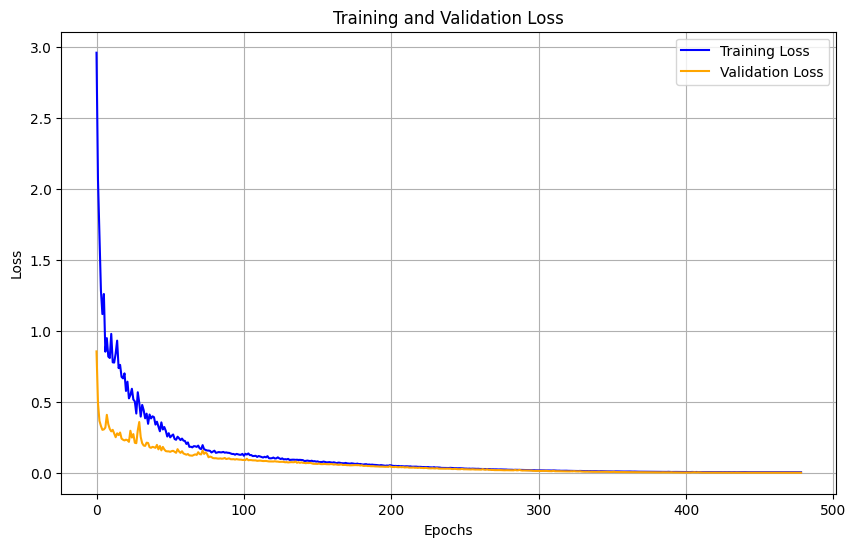

In [745]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
MAE 149560.68650112153
 MSE 55415139546.43799
 MAPE 0.06411770437906054
 R2 0.6276098338503322



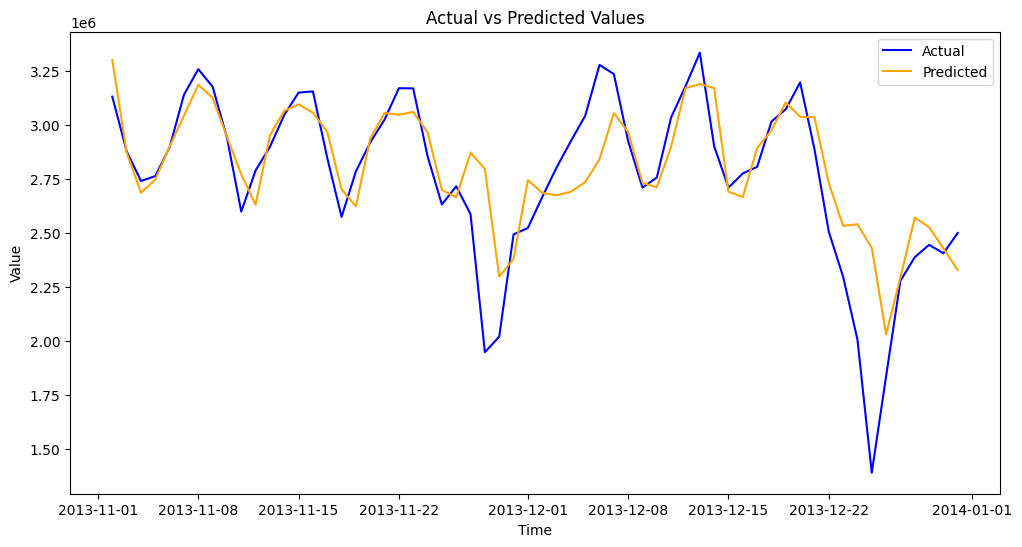

In [746]:
from sklearn.metrics import mean_squared_error

y_pred = gru.predict(x_test)
y_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

mae = mean_absolute_error(y_inv, y_pred)
mse = mean_squared_error(y_inv, y_pred)
mape = mean_absolute_percentage_error(y_inv, y_pred)
r2 = r2_score(y_inv, y_pred)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[-len(y_test):], y_inv, label="Actual", color="blue")
plt.plot(df_lstm.index[-len(y_test):], y_pred, label="Predicted", color="orange")
plt.title("Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [752]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

gru = Sequential([
    GRU(256, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    BatchNormalization(),
    Dropout(0.3),
    GRU(128, activation='tanh', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

gru.compile(optimizer='adam', loss='mse')

history = gru.fit(x_train, y_train, epochs=1000, batch_size=16, validation_data=(x_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1)],
                   verbose=1)

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.7890 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6540 - val_loss: 0.3600 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4814 - val_loss: 0.3227 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3623 - val_loss: 0.3172 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0725 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4085 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2604 - val_loss: 0.3025 - learning_rate: 0.0010
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8161 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 9/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9988 - val_loss: 0.2880 - learning_rate: 0.0010
Ep

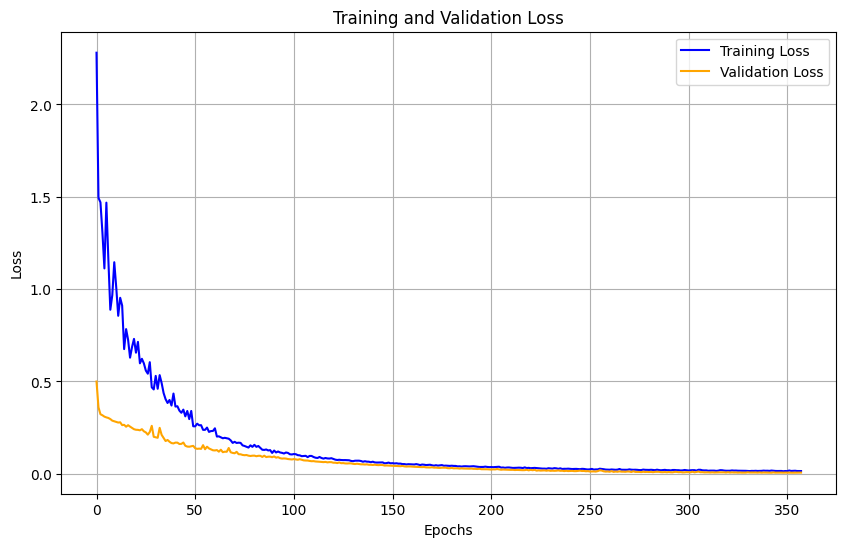

In [753]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
MAE 296057.80342377414
 MSE 181482926595.71664
 MAPE 0.28171966875432464
 R2 0.6714948067966595



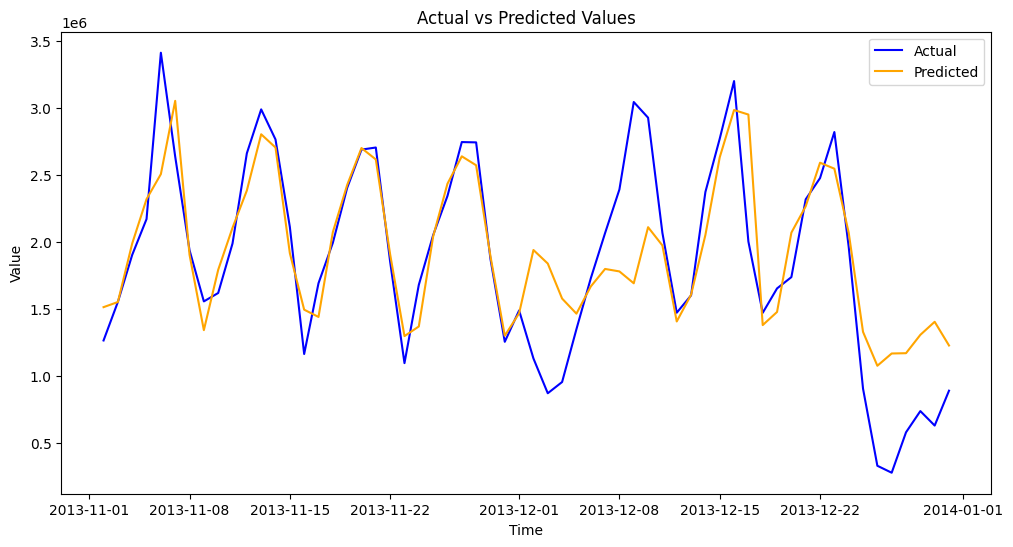

In [754]:
from sklearn.metrics import mean_squared_error

y_pred = gru.predict(x_test)
y_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

mae = mean_absolute_error(y_inv, y_pred)
mse = mean_squared_error(y_inv, y_pred)
mape = mean_absolute_percentage_error(y_inv, y_pred)
r2 = r2_score(y_inv, y_pred)

print(f'MAE {mae}\n MSE {mse}\n MAPE {mape}\n R2 {r2}\n')

plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[-len(y_test):], y_inv, label="Actual", color="blue")
plt.plot(df_lstm.index[-len(y_test):], y_pred, label="Predicted", color="orange")
plt.title("Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()